In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import netCDF4
from global_land_mask import globe
import matplotlib as mpl
from scipy.optimize import curve_fit
import metpy.calc as mpcalc
from metpy.units import units
import scipy
import metpy
from sklearn.linear_model import LinearRegression
mpl.rcParams['figure.dpi']= 500

g = 9.80616
Cp = 1004.64
Lv = 2.501e6
#R = 8.34
R = 287

# Constant explicit for CMIP6

In [2]:
a = '/media/rakshith/Seagate Expansion Drive/Good models/CMCC/MSE/*.nc'
#a = '/home/rakshith/Good models/INM-CM5-0/MSE/*.nc'
#a = '/home/rakshith/Good models/E3SM-1-0/MSE/*.nc'  #E3SM
ds1 = xr.open_mfdataset(a)

In [37]:
region = str(input('Enter the region for comparision\n I=India, SA=South Africa, NA=North Africa, Am=South America\n'))
                   
if region=='I':
        lat1, lat2, lon1, lon2 = 10, 30, 70, 90
        region='India'
elif region=='Af':
        lat1, lat2, lon1, lon2 = -20, -5, 20, 40
        region='South Africa'
elif region=='SA':
        lat1, lat2, lon1, lon2 = -20, -10, 290, 310
        region='South America'
elif region=='NA':
        lat1, lat2, lon1, lon2 = 10, 20, 290, 310
        region='North America'
else:
    print('Please enter proper code')

Enter the region for comparision
 I=India, SA=South Africa, NA=North Africa, Am=South America
NA


In [38]:
grid1 = ds1.sel(plev=slice(100000,10000), lat=slice(lat1,lat2), lon=slice(lon1,lon2))
l=[]
for i in grid1.lon:
    if i>180:
        l.append(i-360)
    else:
        l.append(i)
            
lon_grid, lat_grid = np.meshgrid(l, grid1.lat)
mask1 = globe.is_land(lat_grid, lon_grid)

jjas = grid1.time.dt.month.isin(range(6, 10)) #JJAS
clim = grid1.sel(time=jjas)
#clim = clim.groupby('time.year').mean('time')
clim = clim.resample(time="10AS").mean()

In [39]:
q = clim.hus.where(mask1>0).mean(dim=['lat', 'lon']).squeeze()
q0 = q.sel(plev=100000)
divq = np.divide(q,q0)

p=clim.plev
p0=100000
divp = np.divide(p,p0)

T = clim.ta.where(mask1>0).mean(dim=['lat', 'lon']).squeeze()
T0 = T.sel(plev=100000)

z = clim.zg.where(mask1>0).mean(dim=['lat', 'lon']).squeeze()

In [14]:
#for CMCC
Tmean = np.array([258.64545, 258.33508, 258.54745, 258.19376, 258.34805, 258.3052 ,
       258.44183, 258.66403, 258.55896, 258.5717 , 258.62616, 258.62857,
       258.73166, 259.13635, 258.96463, 259.55542, 259.82153, 260.1595 ,
       260.63565, 261.39807, 261.84085, 262.89236, 263.43573, 264.1497 ,
       265.106  , 265.79486])

In [47]:
Tmean = np.array([256.94342, 256.88306, 256.8857 , 256.70752, 256.77023, 256.86557,
       256.71582, 256.90906, 256.98837, 256.9243 , 257.0541 , 256.78793,
       256.78903, 257.0219 , 257.1163 , 257.50613, 258.04153, 258.56567,
       259.38736, 260.1987 , 260.90555, 261.8049 , 262.8919 , 264.33224,
       265.59225])

In [46]:
T.mean(dim='plev').values

array([256.94342, 256.88306, 256.8857 , 256.70752, 256.77023, 256.86557,
       256.71582, 256.90906, 256.98837, 256.9243 , 257.0541 , 256.78793,
       256.78903, 257.0219 , 257.1163 , 257.50613, 258.04153, 258.56567,
       259.38736, 260.1987 , 260.90555, 261.8049 , 262.8919 , 264.33224,
       265.59225], dtype=float32)

In [ ]:
regr = LinearRegression()
gammalist=[]
lambdalist=[]
for k in clim.time:
    x1, y1 = np.log(divq.sel(time=k)).values.reshape(-1, 1), np.log(divp).values.reshape(-1, 1)
    regr.fit(x1, y1)
    y_pred1 = regr.predict(x1)
    lambda1 = regr.coef_[0][0]
    lambdalist.append(lambda1)
    
    x2, y2 = z.sel(time=k).values.reshape(-1, 1), T.sel(time=k).values.reshape(-1, 1)
    regr.fit(x2, y2)
    y_pred2 = regr.predict(x2)
    gamma1 = regr.coef_[0][0]
    gammalist.append(gamma1) 

In [ ]:
gammalist

In [2]:
# for E3SM
gammalist = [-0.006684738,
 -0.0066918223,
 -0.0066941762,
 -0.0066934703,
 -0.006686151,
 -0.0067018857,
 -0.0067088893,
 -0.0067102155,
 -0.0067023737,
 -0.006692417,
 -0.00669165,
 -0.006686449,
 -0.006675833,
 -0.006672587,
 -0.0066381013,
 -0.0065806992,
 -0.0065490482,
 -0.0065050987,
 -0.006459704,
 -0.006398781,
 -0.0063510947,
 -0.0062789274,
 -0.00620556,
 -0.006116225,
 -0.006007272]

lambdalist = [0.25359577,
 0.2531987,
 0.2529248,
 0.25291198,
 0.25225607,
 0.2536445,
 0.25358692,
 0.2540904,
 0.25355467,
 0.25329405,
 0.2540131,
 0.25379077,
 0.2550618,
 0.25623125,
 0.2564376,
 0.25735658,
 0.26009777,
 0.26147327,
 0.2645437,
 0.26795283,
 0.27043852,
 0.2757811,
 0.28087407,
 0.28788832,
 0.29713106]

255.711599 * Gamma -49.081943


Text(0.5, 1.0, 'Model: E3SM-1-0, decadal averages')

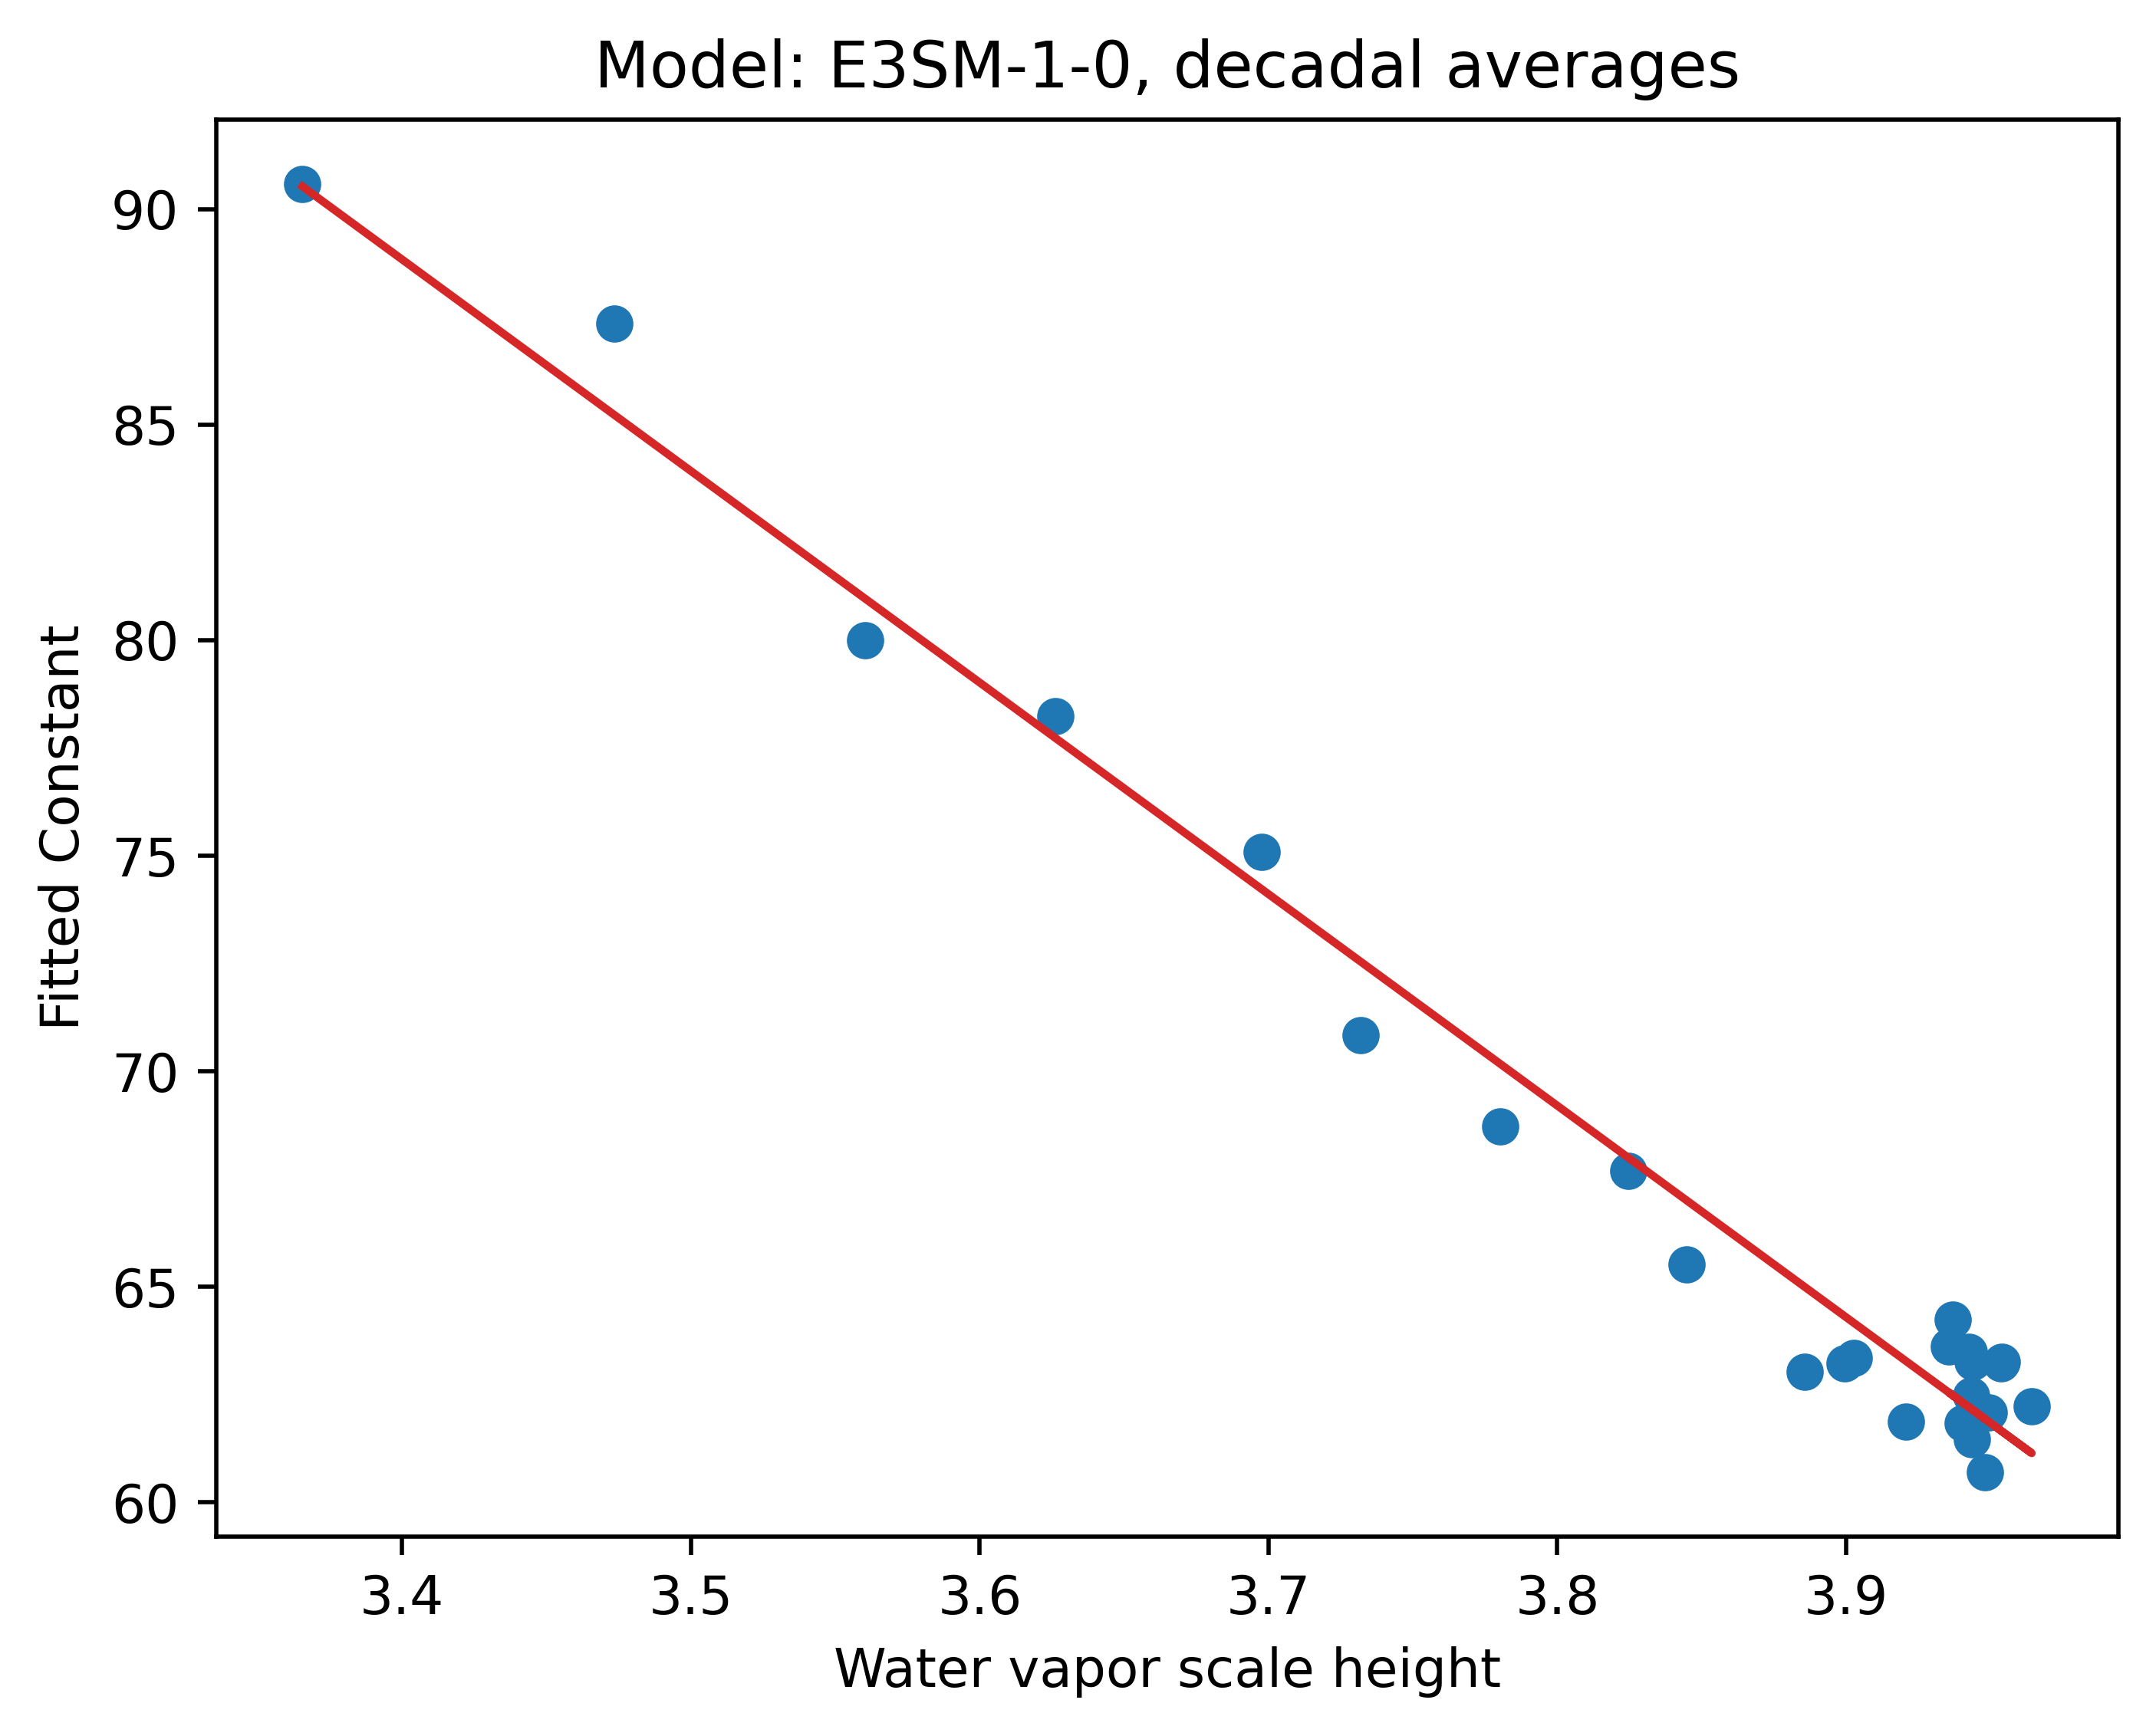

In [7]:
predconst = np.array([62.48434 , 62.085827, 63.221172, 63.261707, 62.23023 , 63.483883,
       61.458748, 63.620586, 63.263443, 60.704353, 64.239525, 61.834354,
       61.87412 , 63.343697, 63.21644 , 63.033085, 65.51825 , 67.68671 ,
       68.72139 , 70.844666, 75.08645 , 78.24225 , 79.998665, 87.34836 ,
       90.58937 ])

lambdalist = np.divide(1, lambdalist)
plt.scatter(lambdalist, predconst)

def f(g, a, b):
    return a  + b * g

popt1, _ = curve_fit(f, lambdalist, predconst)
a1, b1 = popt1


print('%5f * Gamma %5f' % (a1, b1))

y_line1 = f(lambdalist, a1, b1)
plt.plot(lambdalist, y_line1, c='tab:red', label='Fit line')
plt.ylabel('Fitted Constant')
plt.xlabel('Water vapor scale height')
plt.title('Model: E3SM-1-0, decadal averages')

380.672381 * Gamma -48219.675283


Text(0.5, 1.0, 'Model: E3SM-1-0, decadal averages')

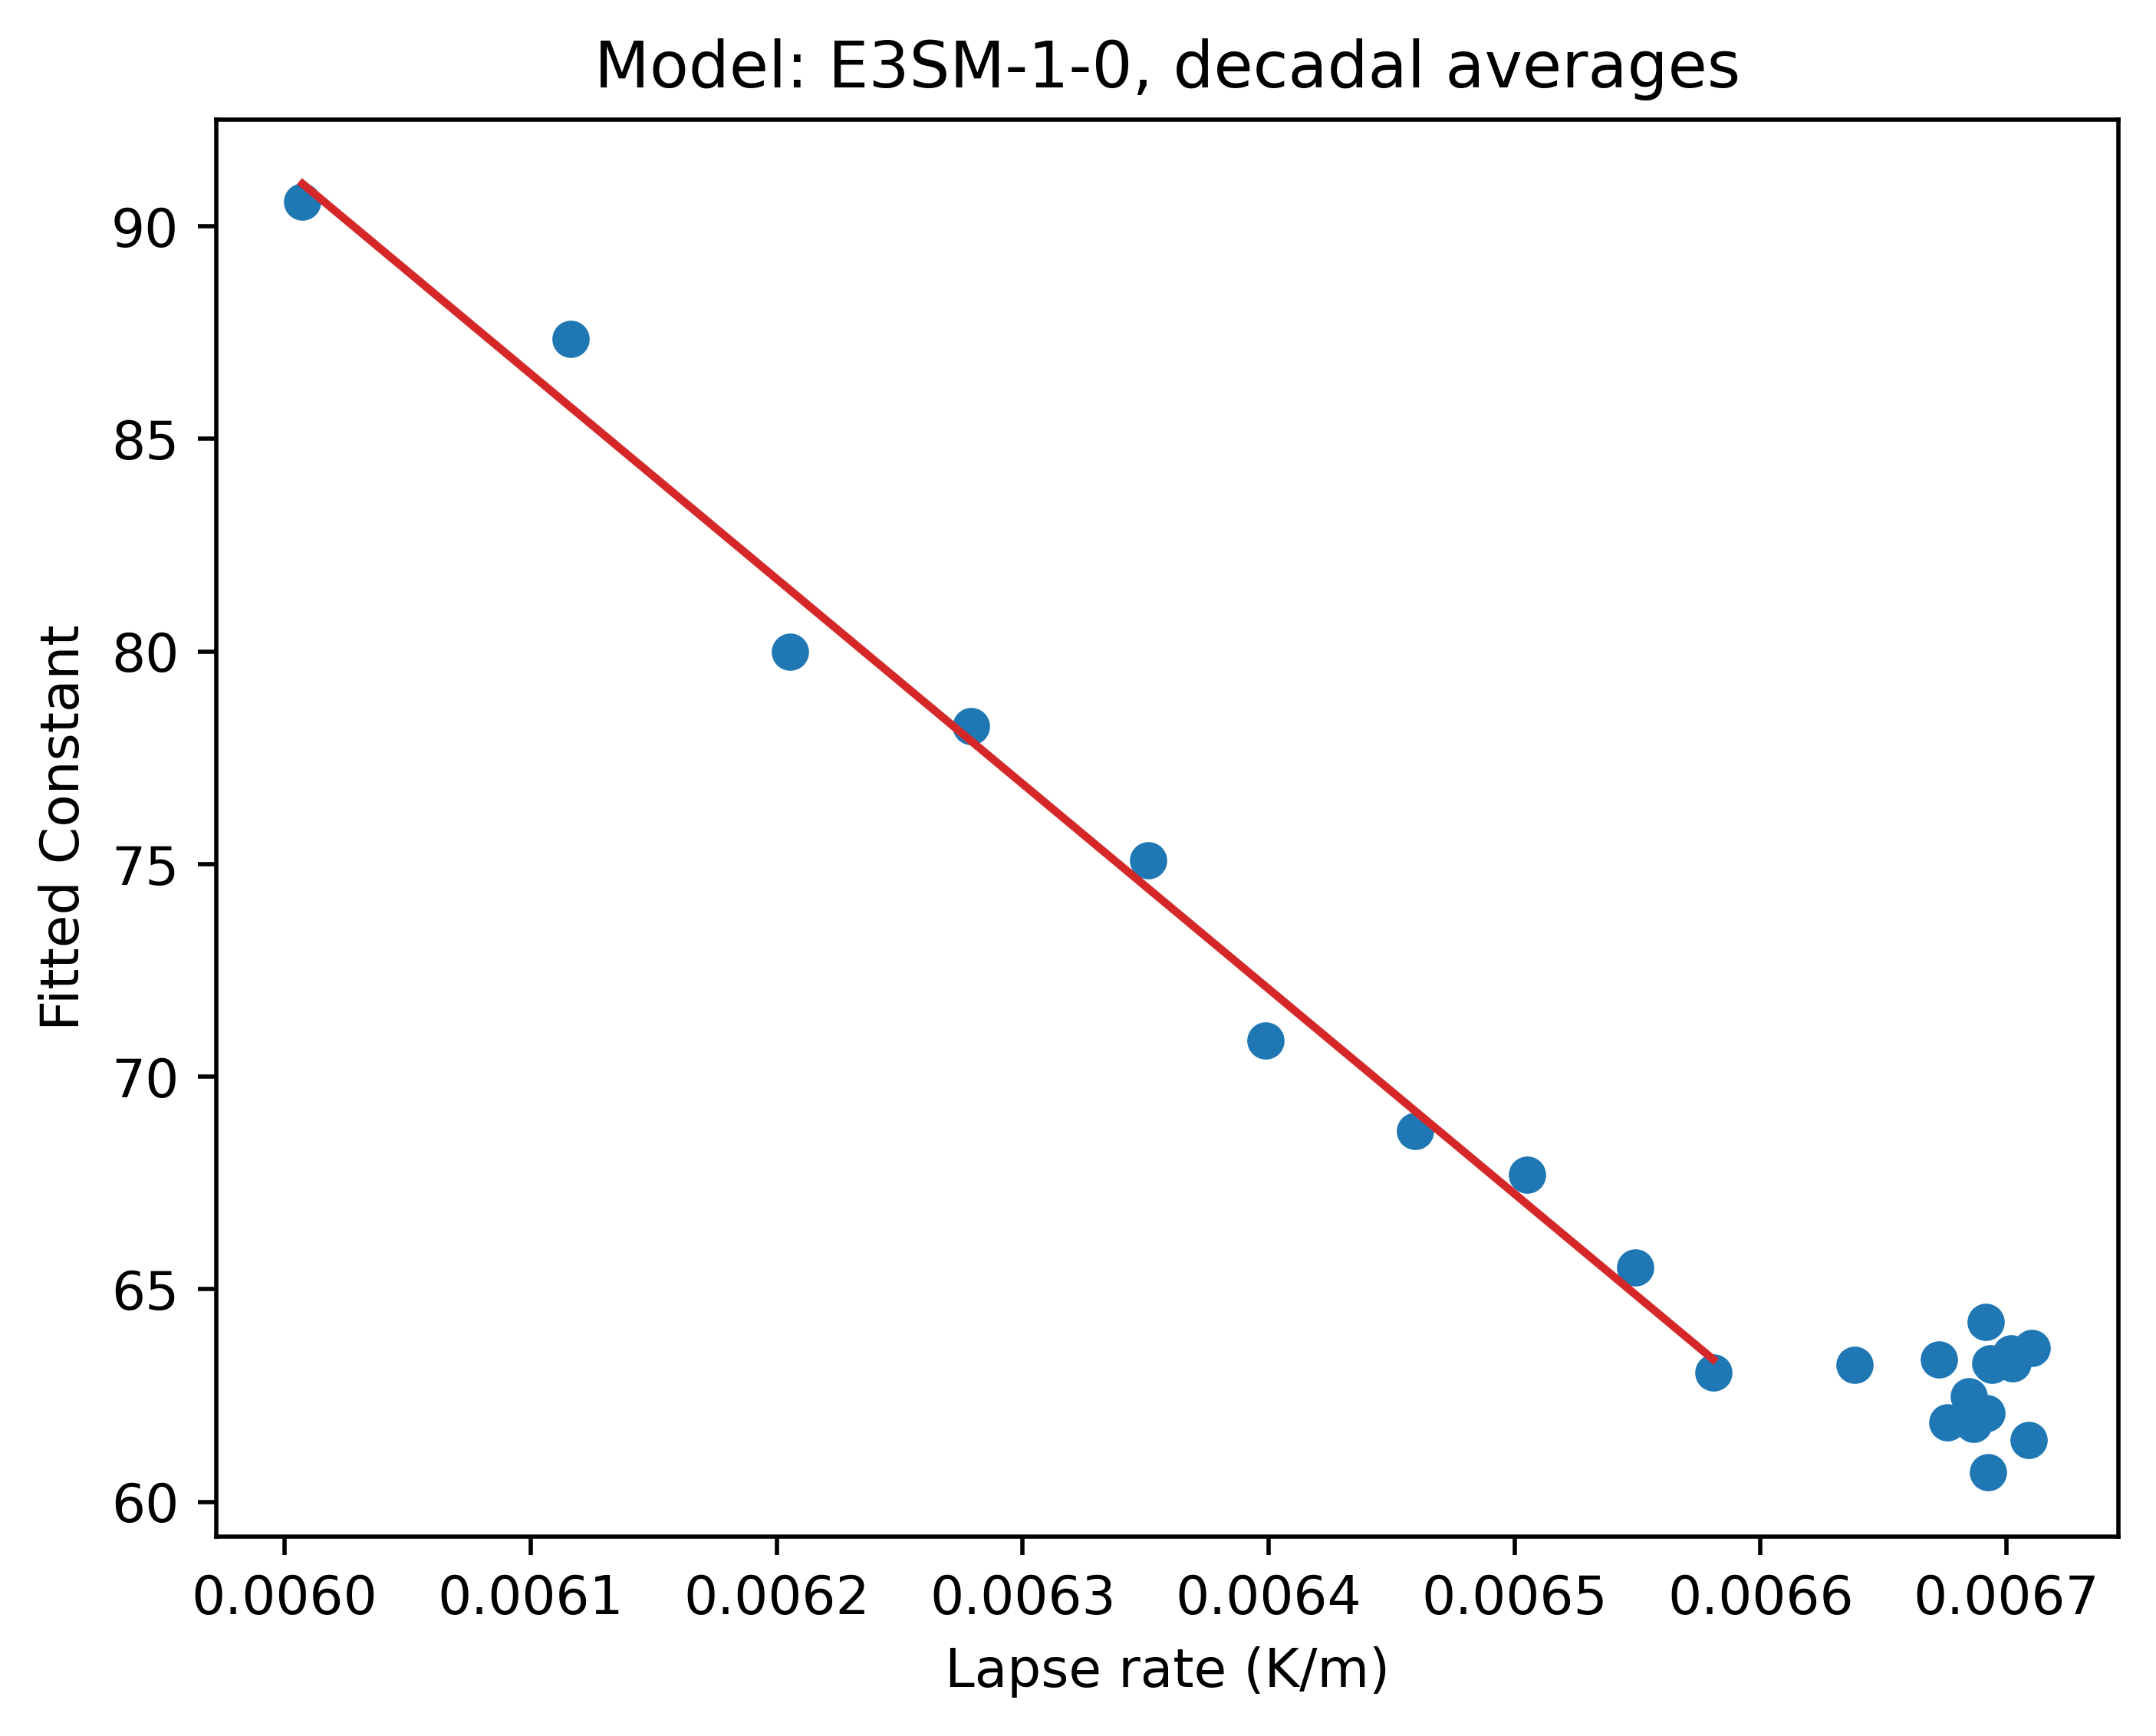

In [23]:
predconst = np.array([62.48434 , 62.085827, 63.221172, 63.261707, 62.23023 , 63.483883,
       61.458748, 63.620586, 63.263443, 60.704353, 64.239525, 61.834354,
       61.87412 , 63.343697, 63.21644 , 63.033085, 65.51825 , 67.68671 ,
       68.72139 , 70.844666, 75.08645 , 78.24225 , 79.998665, 87.34836 ,
       90.58937 ])

gammalist = abs(np.array(gammalist))
plt.scatter(gammalist, predconst)

def f(g, a, b):
    return a  + b * g

popt1, _ = curve_fit(f, gammalist[15:], predconst[15:])
a1, b1 = popt1


print('%5f * Gamma %5f' % (a1, b1))

y_line1 = f(gammalist[15:], a1, b1)
plt.plot(gammalist[15:], y_line1, c='tab:red', label='Fit line')
plt.ylabel('Fitted Constant')
plt.xlabel('Lapse rate (K/m)')
plt.title('Model: E3SM-1-0, decadal averages')

In [24]:
y_line1

array([63.35320262, 64.87940356, 66.99863418, 69.18755187, 72.12523915,
       74.42465705, 77.90454082, 81.44229303, 85.74999772, 91.003676  ])

In [2]:
#for CMCC
gammalist = [-0.006603245,
 -0.006599083,
 -0.0065960977,
 -0.0066038403,
 -0.0066116424,
 -0.0065933405,
 -0.0065803155,
 -0.0065750983,
 -0.006560706,
 -0.0065873074,
 -0.00656016,
 -0.0065628802,
 -0.006537746,
 -0.0065112878,
 -0.0065108794,
 -0.006469703,
 -0.006423036,
 -0.0064056376,
 -0.006349389,
 -0.006306395,
 -0.0062555033,
 -0.0061852266,
 -0.006152857,
 -0.006106478,
 -0.0060531185,
 -0.0060054637]

lambdalist = [0.26249778,
 0.2610857,
 0.26162052,
 0.26095656,
 0.26133952,
 0.26101527,
 0.2617906,
 0.26248637,
 0.2617599,
 0.26238784,
 0.2627733,
 0.26271573,
 0.26347834,
 0.26488745,
 0.26456678,
 0.26651713,
 0.26755127,
 0.26983267,
 0.27173486,
 0.27472967,
 0.27699035,
 0.2818377,
 0.28356212,
 0.2874871,
 0.29198483,
 0.29661223]

347.75911221076353 -42932.38000097615


Text(0.2, 0.3, 'C = 348 - 42932*Γ')

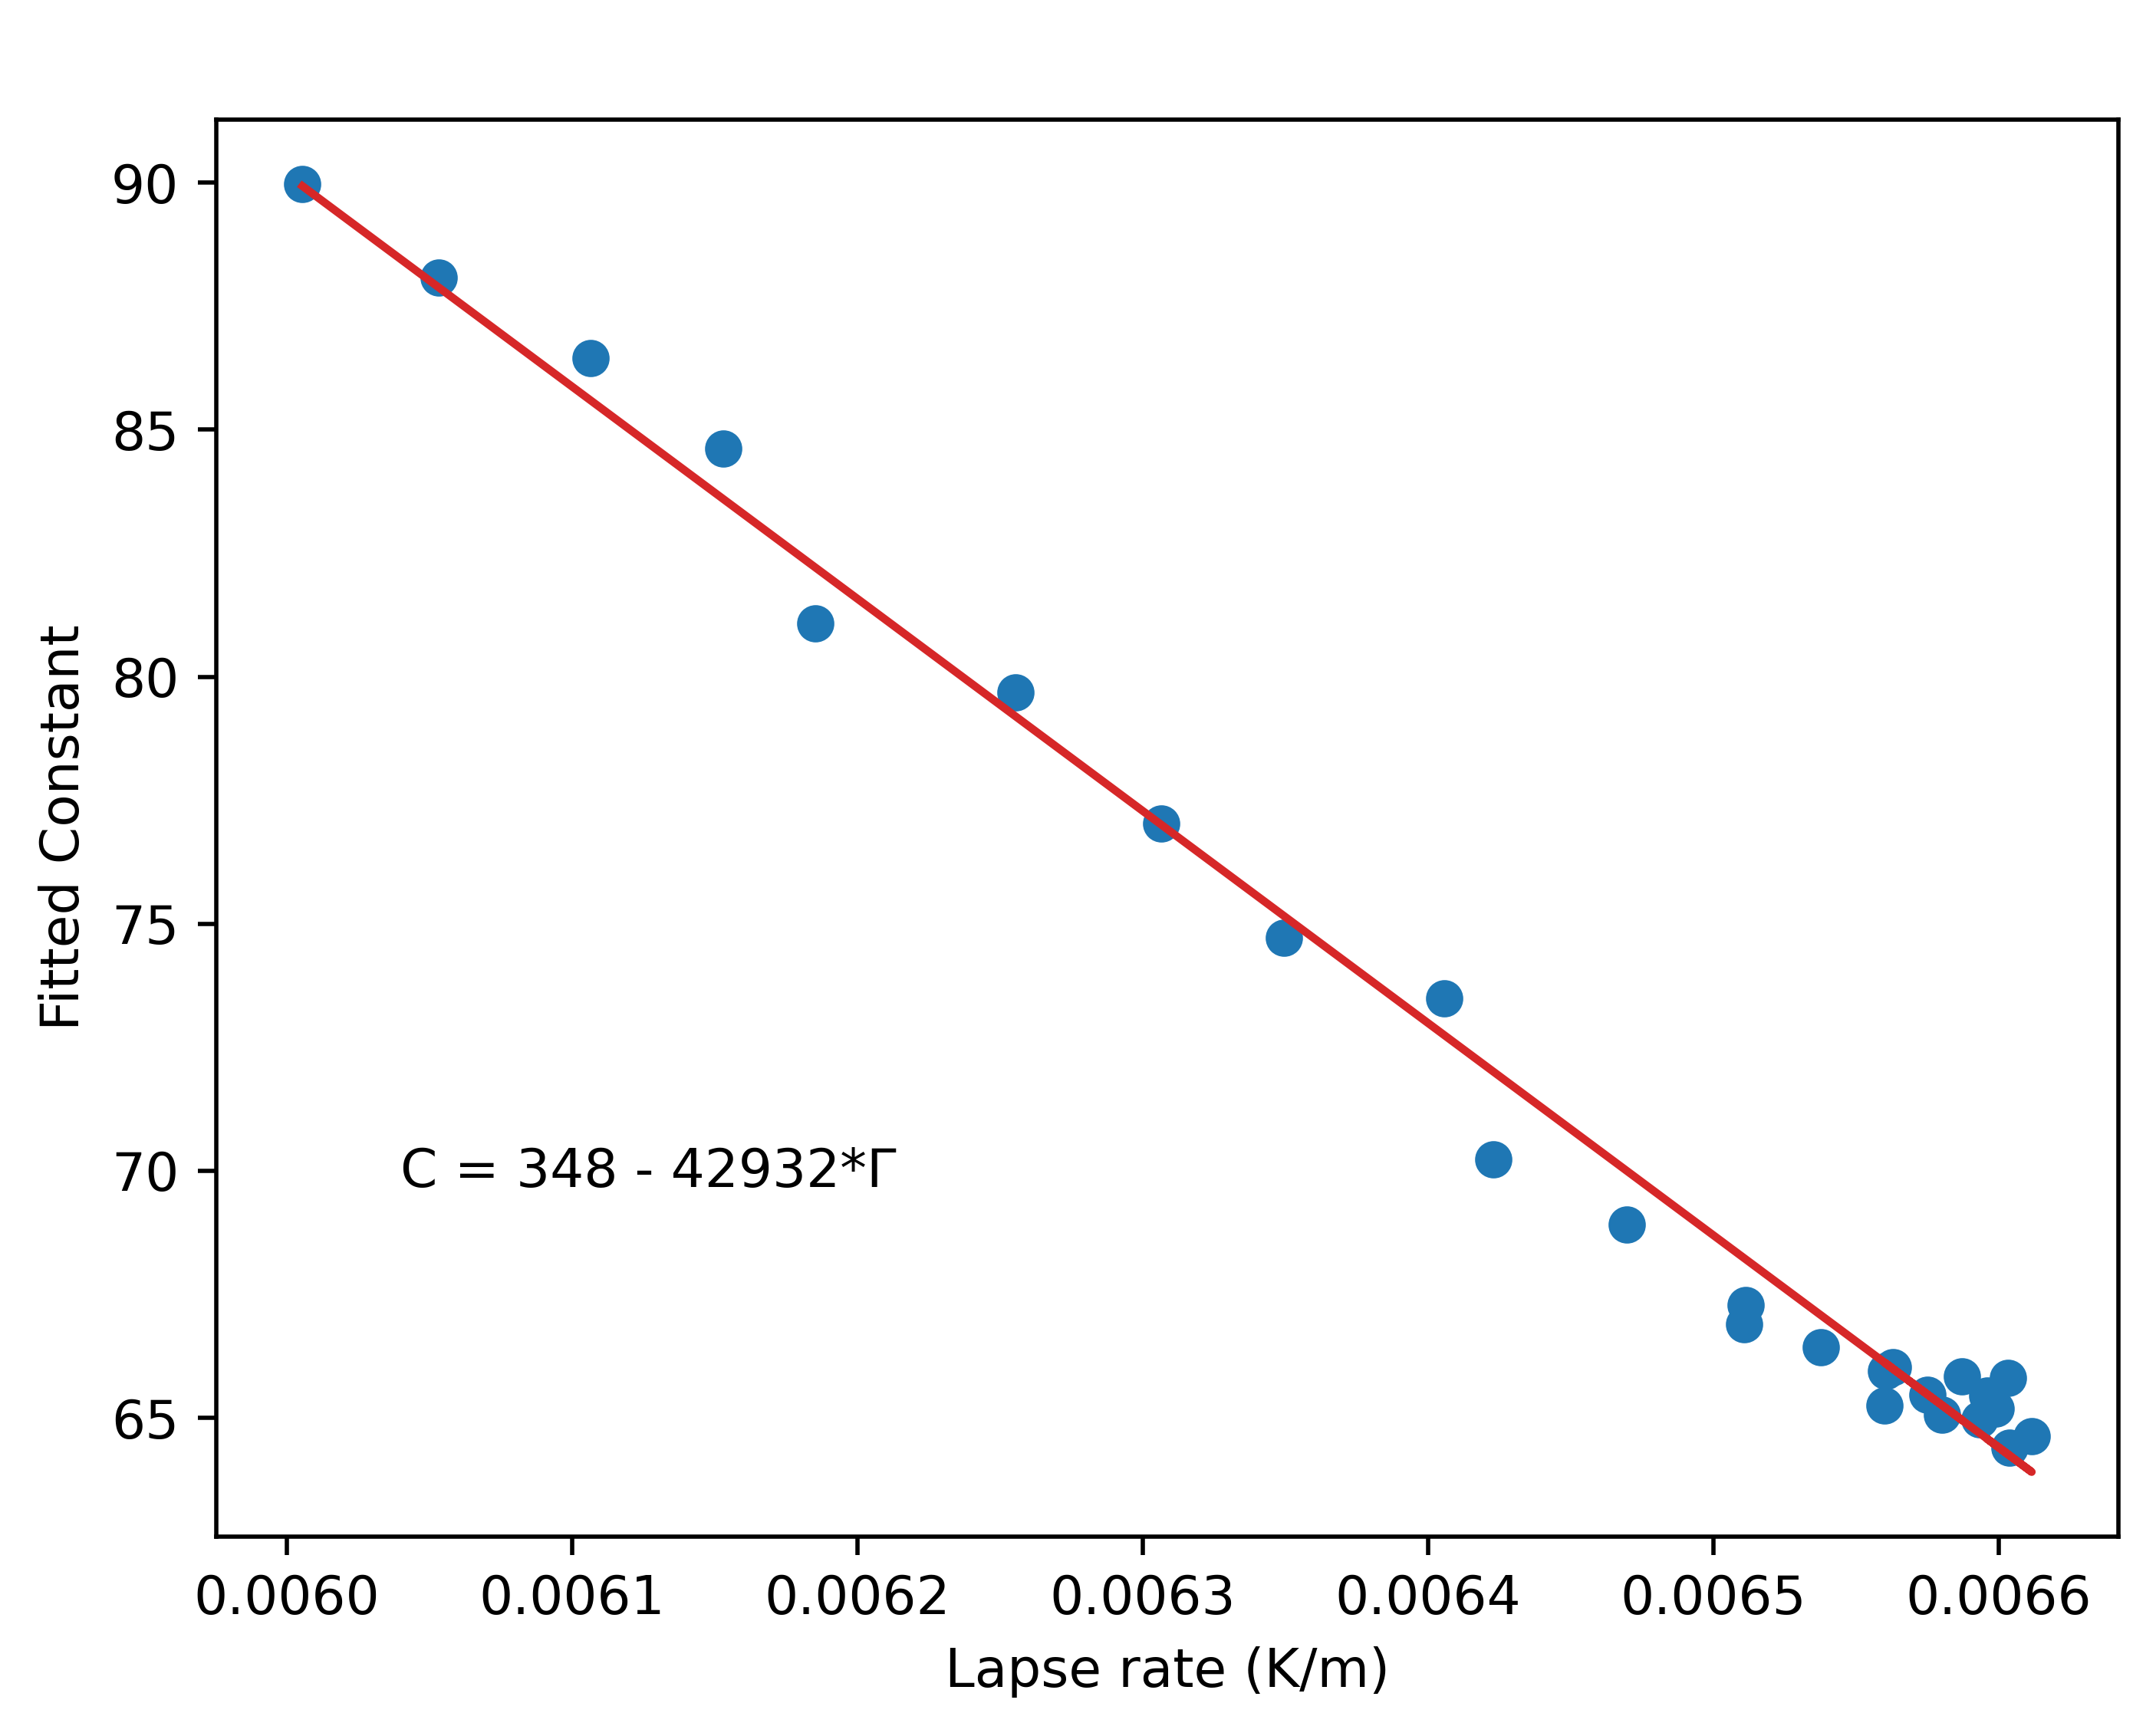

In [23]:
gammalist = abs(np.array(gammalist))
predconst = np.array([65.80152 , 65.189705, 65.45315 , 64.39255 , 64.63362 , 64.974594,
       65.06264 , 65.46419 , 65.9547  , 65.83267 , 65.244194, 66.02322 ,
       66.42661 , 67.28108 , 66.893196, 68.91873 , 70.23039 , 73.48774 ,
       74.70993 , 77.022995, 79.68398 , 81.0798  , 84.61071 , 86.447525,
       88.07539 , 89.97855 ])
plt.scatter(gammalist, predconst)

def f(g, a, b):
    return a  + b * g

popt1, _ = curve_fit(f, gammalist, predconst)
a1, b1 = popt1


print(a1, b1)

y_line1 = f(gammalist, a1, b1)
plt.plot(gammalist, y_line1, c='tab:red', label='Fit line')
plt.ylabel('Fitted Constant')
plt.xlabel('Lapse rate (K/m)')
#plt.title('Model: CMCC-CM2-SR5, decadal averages')
plt.title('  ')
plt.figtext(0.2, 0.3, 'C = %.0f - %.0f*\u0393' % (abs(a1), abs(b1)))

In [21]:
y_line1

array([69.29587031, 71.42563839, 72.21965894, 74.78670787, 76.74884919,
       79.07142227, 82.27867949, 83.75594909, 85.87257356, 88.30777101,
       90.48261988])

In [3]:
gammalist = abs(np.array(gammalist))
lambdalist = np.divide(1, lambdalist)

In [4]:
X1 = np.arange(1850, 2100, 10)

Text(0.7, 0.7, 'r = -0.994')

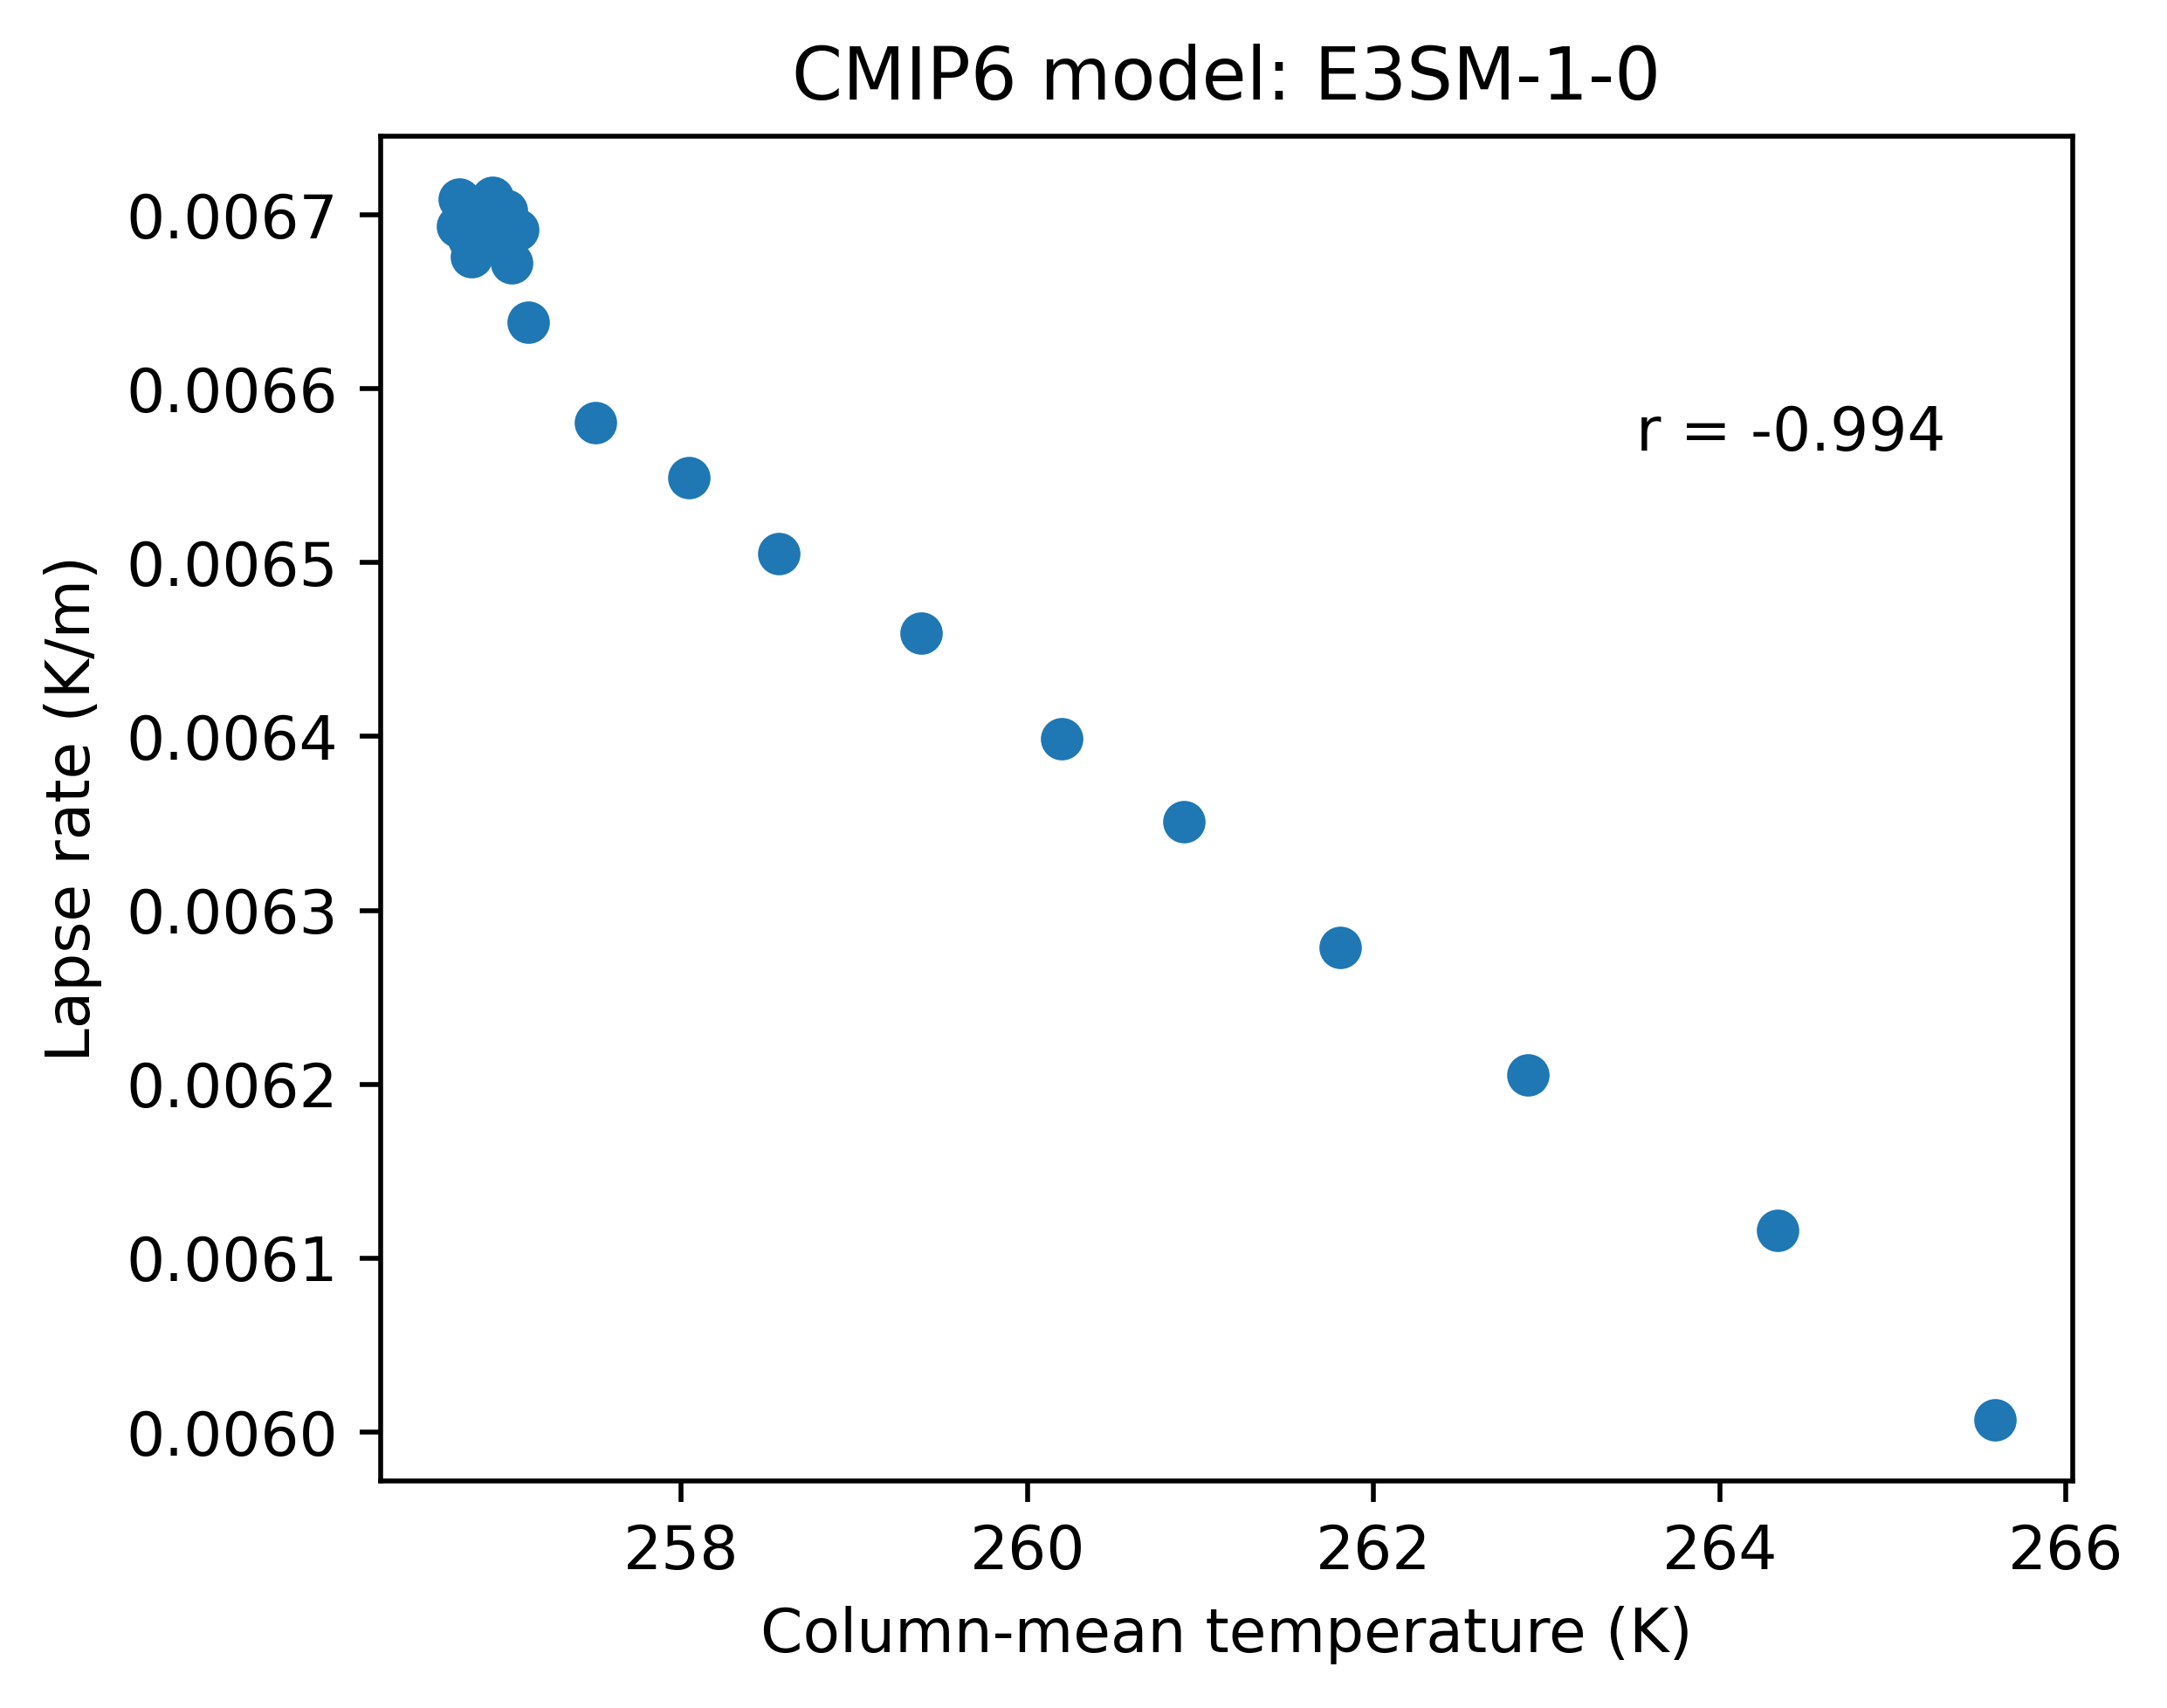

In [54]:
corr = np.corrcoef(Tmean, gammalist)[0][1]
plt.scatter(Tmean, gammalist)
plt.ylabel('Lapse rate (K/m)')
plt.xlabel('Column-mean temperature (K)')
plt.title('CMIP6 model: E3SM-1-0')
plt.figtext(0.7, 0.7, 'r = %0.3f'%(corr))

In [34]:
l=lambdalist
a=g/(np.multiply(Cp, gammalist))
b=np.multiply(R, gammalist)/g

p0=100000
num = p0*(a-1)*b*(np.array(l)+2)*Cp*T0
den = Lv*g*np.array(l)*(b+1)*(b+2)

constref = np.average(num/den)
const = num/den
constref

73.1112247281835

In [35]:
#INM over africa
const.values

array([71.67305415, 71.75556184, 71.74277154, 71.48940883, 71.63969324,
       72.11855561, 71.73140708, 72.30695192, 72.02859183, 72.38629598,
       72.37643252, 72.0072144 , 72.21212037, 72.19314995, 72.23776254,
       72.83687318, 72.77110786, 73.07951817, 73.31199666, 73.99639099,
       74.60619821, 75.21602338, 75.60965453, 76.06242391, 76.5661761 ,
       76.93650816])

In [11]:
# const with lambda unchanging
l=lambdalist[0]
a=g/(np.multiply(Cp, gammalist))
b=np.multiply(R, gammalist)/g

p0=100000
num = p0*(a-1)*b*(np.array(l)+2)*Cp*T0
den = Lv*g*np.array(l)*(b+1)*(b+2)

gammachangeconst = num/den

In [12]:
# const with gamma unchanging
l=lambdalist
a=g/(np.multiply(Cp, gammalist[0]))
b=np.multiply(R, gammalist[0])/g

p0=100000
num = p0*(a-1)*b*(np.array(l)+2)*Cp*T0
den = Lv*g*np.array(l)*(b+1)*(b+2)

lambdachangeconst = num/den

In [13]:
lambdachangeconst.values

array([73.4984  , 73.40457 , 73.47145 , 73.40614 , 73.484825, 73.56485 ,
       73.58238 , 73.61199 , 73.60899 , 73.63066 , 73.76453 , 73.55297 ,
       73.71187 , 73.65347 , 73.75673 , 73.828026, 73.935875, 74.03898 ,
       74.24353 , 74.28013 , 74.67194 , 74.77536 , 75.16707 , 75.225624,
       75.48254 , 75.56428 ], dtype=float32)

In [14]:
gammachangeconst.values

array([73.49838646, 73.43917686, 73.39672394, 73.20992222, 73.15344419,
       73.92507393, 73.47579138, 73.91405478, 73.91344346, 74.26276682,
       73.92055647, 74.0451119 , 74.19300861, 73.76136611, 74.23147699,
       74.42644566, 74.76775351, 75.17804956, 75.85458505, 76.54452286,
       77.04528766, 78.13110242, 78.43811097, 79.20676006, 79.85264655,
       80.72681459])

In [33]:
#for E3SM
const = np.array([63.75757215, 63.56127312, 63.51277435, 63.46550142, 63.53876508,
       63.38034078, 63.22108875, 63.28314839, 63.41004876, 63.54834587,
       63.85901605, 63.73813712, 64.19271289, 64.2944398 , 65.04772848,
       66.52385219, 67.64697061, 68.8251964 , 70.3804166 , 72.18264474,
       73.75402252, 76.20640376, 78.609491  , 82.07032391, 85.95592924])

predconst = array([62.48434 , 62.085827, 63.221172, 63.261707, 62.23023 , 63.483883,
       61.458748, 63.620586, 63.263443, 60.704353, 64.239525, 61.834354,
       61.87412 , 63.343697, 63.21644 , 63.033085, 65.51825 , 67.68671 ,
       68.72139 , 70.844666, 75.08645 , 78.24225 , 79.998665, 87.34836 ,
       90.58937 ])

lambdachangeconst = np.array([63.75757215, 63.72505677, 63.73097972, 63.66719   , 63.57136061,
       63.77695822, 63.77957443, 63.87313713, 63.81820988, 63.72587693,
       64.01955579, 63.7777347 , 63.98587137, 64.01205227, 63.96334267,
       64.09465059, 64.45710026, 64.58675018, 65.02582154, 65.33100462,
       65.70035013, 66.29542249, 66.78754074, 67.78693835, 68.64848825])

gammachangeconst = np.array([63.75757215, 63.59478124, 63.56937385, 63.52314039, 63.65192188,
       63.37624266, 63.22183121, 63.24163912, 63.41350724, 63.57379916,
       63.82367146, 63.72164855, 64.06807615, 64.07037247, 64.80335329,
       66.19351431, 67.06830742, 68.11319441, 69.37259994, 70.8331731 ,
       72.14166731, 74.02709801, 75.86342302, 78.49824317, 81.26144862])

In [6]:
#for CMCC
const = np.array([67.30235106, 67.1580493 , 67.3369692 , 67.00958633, 66.91462166,
       67.26108332, 67.63350725, 67.88832625, 68.09482829, 67.59621112,
       68.24126063, 68.15997685, 68.80207895, 69.64591566, 69.56236382,
       70.78629805, 72.00685607, 72.72516021, 74.29936006, 75.79478864,
       77.28963597, 79.74408092, 80.84099678, 82.57528502, 84.66795873,
       86.57083887])

predconst = np.array([65.80152 , 65.189705, 65.45315 , 64.39255 , 64.63362 , 64.974594,
       65.06264 , 65.46419 , 65.9547  , 65.83267 , 65.244194, 66.02322 ,
       66.42661 , 67.28108 , 66.893196, 68.91873 , 70.23039 , 73.48774 ,
       74.70993 , 77.022995, 79.68398 , 81.0798  , 84.61071 , 86.447525,
       88.07539 , 89.97855 ])

lambdachangeconst = np.array([67.30236 , 67.05908 , 67.166725, 67.02374 , 67.11439 , 67.02563 ,
       67.08764 , 67.21682 , 67.08145 , 67.216156, 67.21284 , 67.19684 ,
       67.236824, 67.439575, 67.34915 , 67.571014, 67.65505 , 67.930664,
       68.11089 , 68.50472 , 68.70816 , 69.31062 , 69.54756 , 70.01369 ,
       70.6105  , 71.151215])

gammachangeconst = np.array([67.30235106, 67.28264555, 67.41453156, 67.14531001, 67.01642634,
       67.39211178, 67.69628991, 67.88933547, 68.16079048, 67.60596278,
       68.21661085, 68I have used the constants from the straight-line fit to calculate precipitation.
Here is another model:.14050029, 68.71371943, 69.4283287 , 69.37412223,
       70.41512682, 71.5327665 , 72.03224234, 73.41006382, 74.59809909,
       75.84801264, 77.77149008, 78.66776723, 79.95492218, 81.51562019,
       82.86350039])

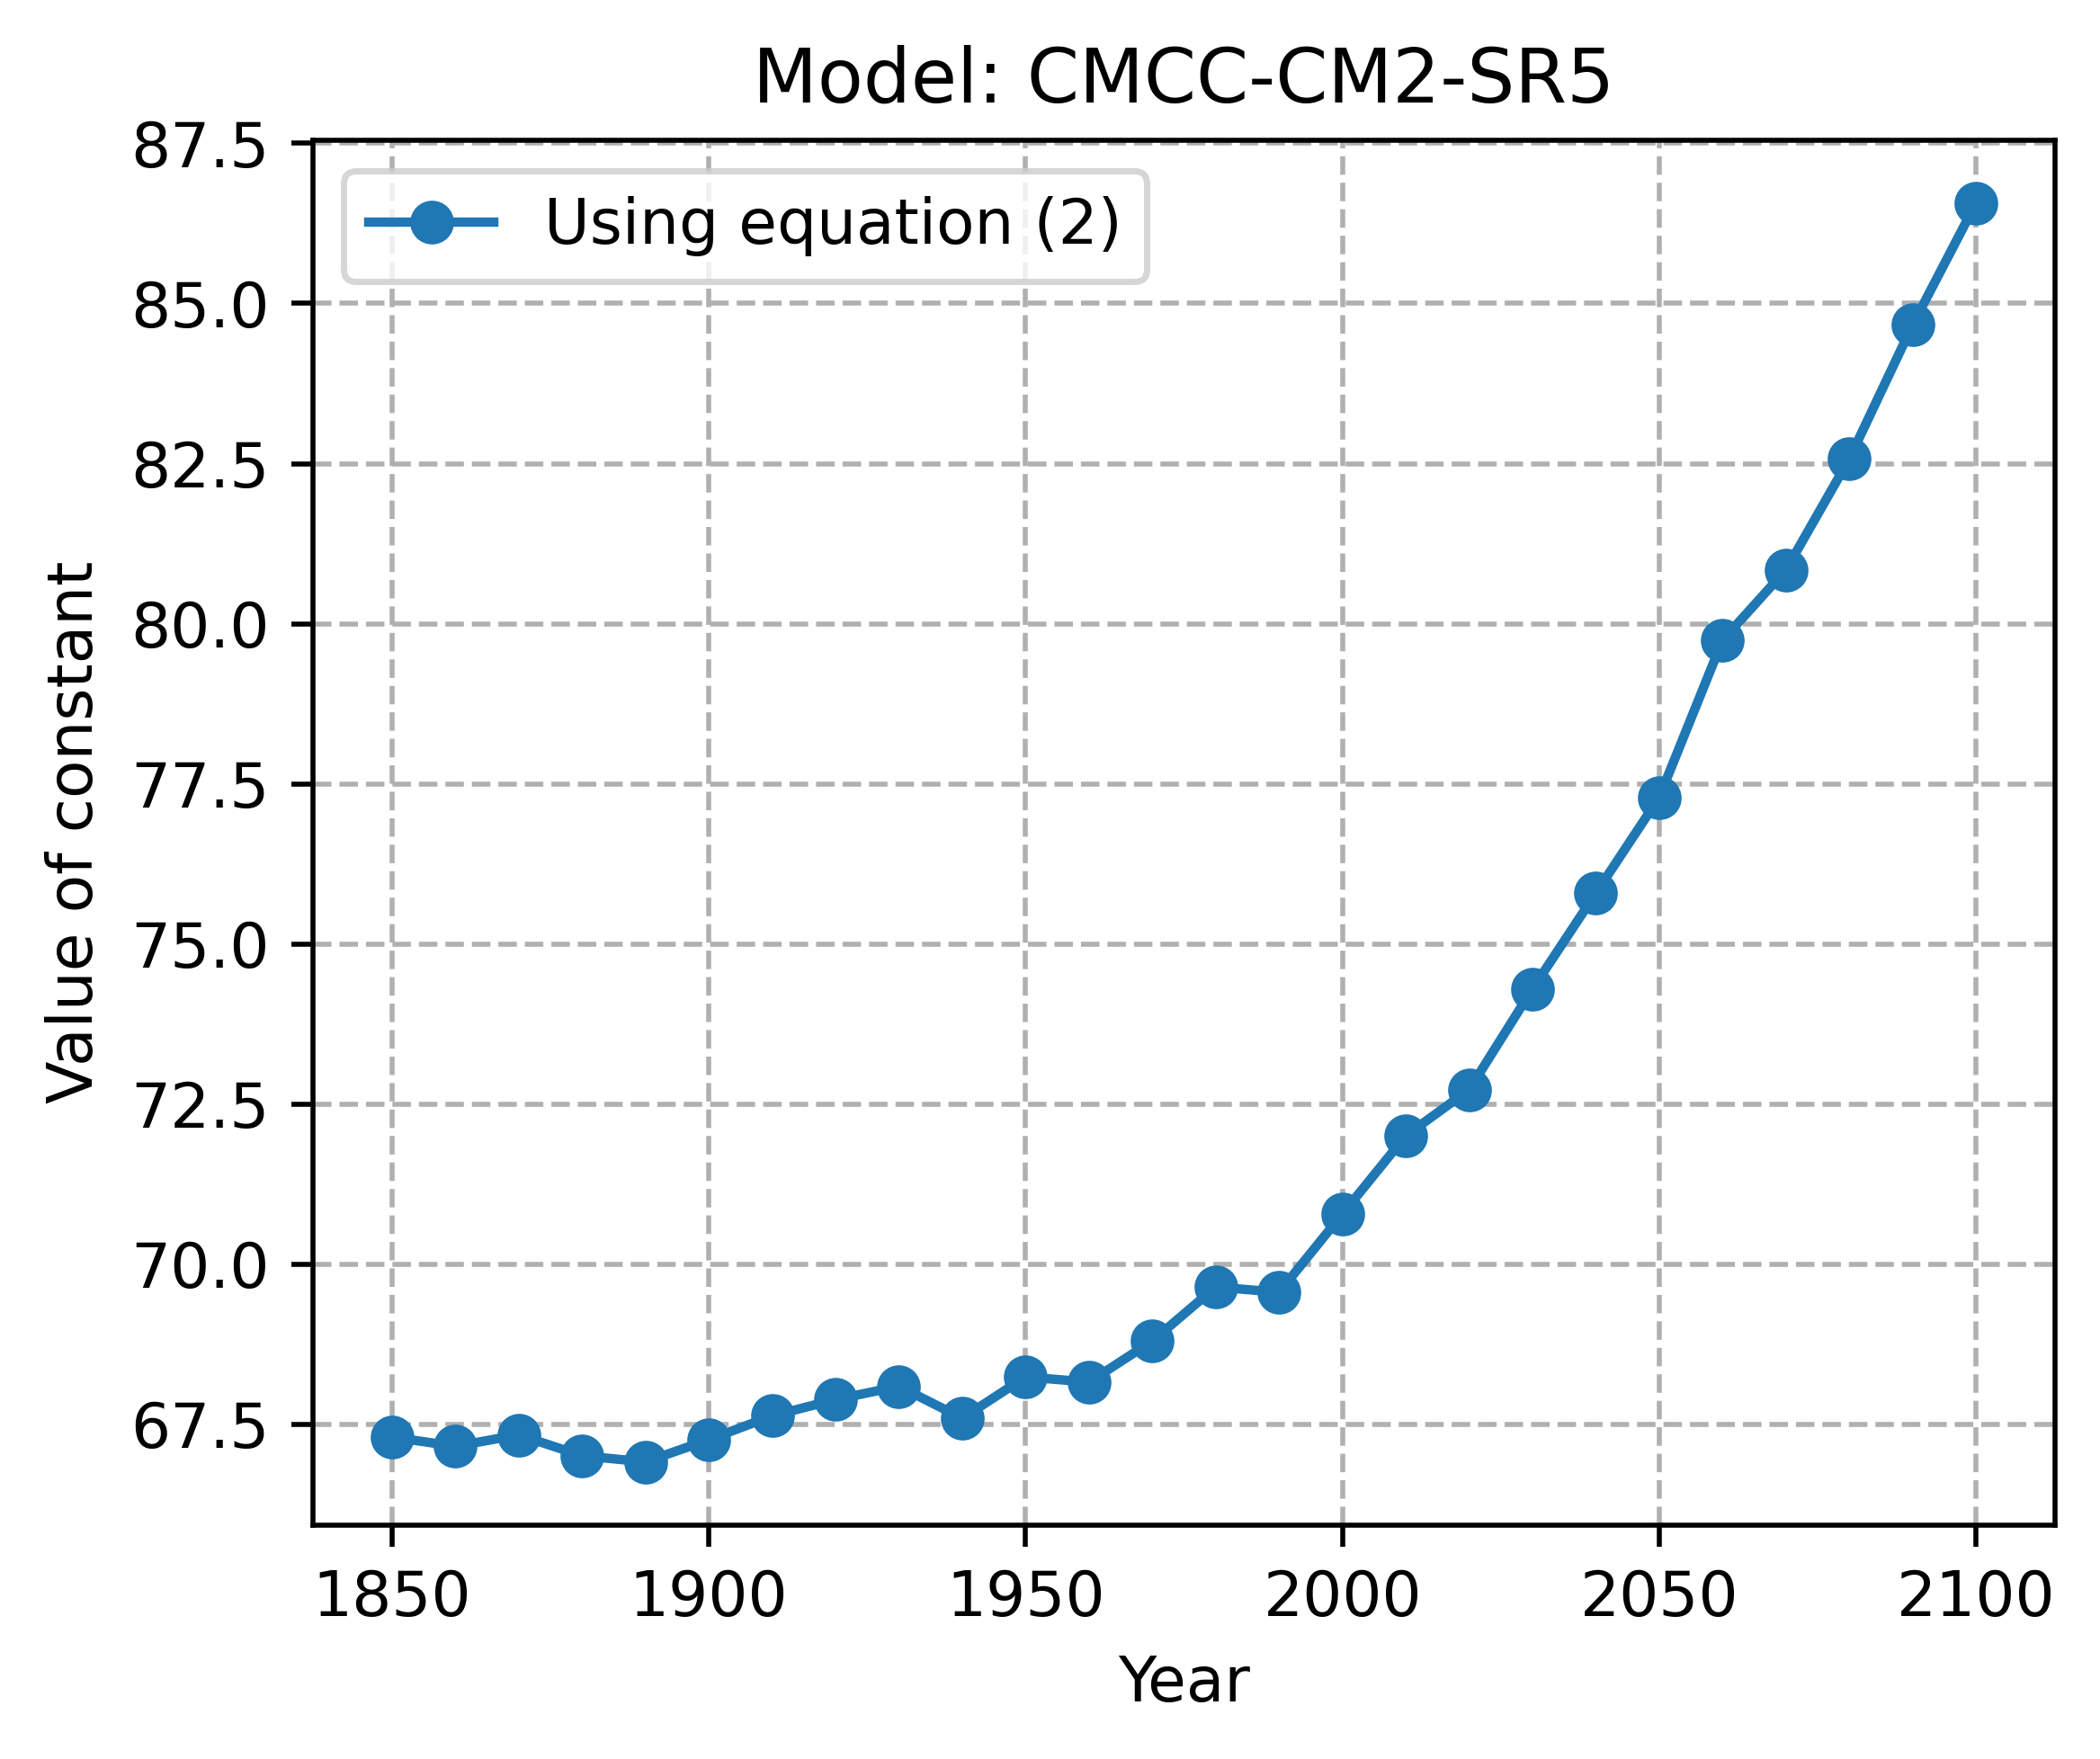

In [3]:
plt.rcParams['figure.figsize'] = [5,4]
X1 = np.arange(1850, 2110, 10)
plt.plot(X1, const, label='Using equation (2)', marker='o')
plt.ylabel('Value of constant')
plt.xlabel('Year')
plt.title('Model: CMCC-CM2-SR5')
plt.grid(linestyle='--')
plt.legend()

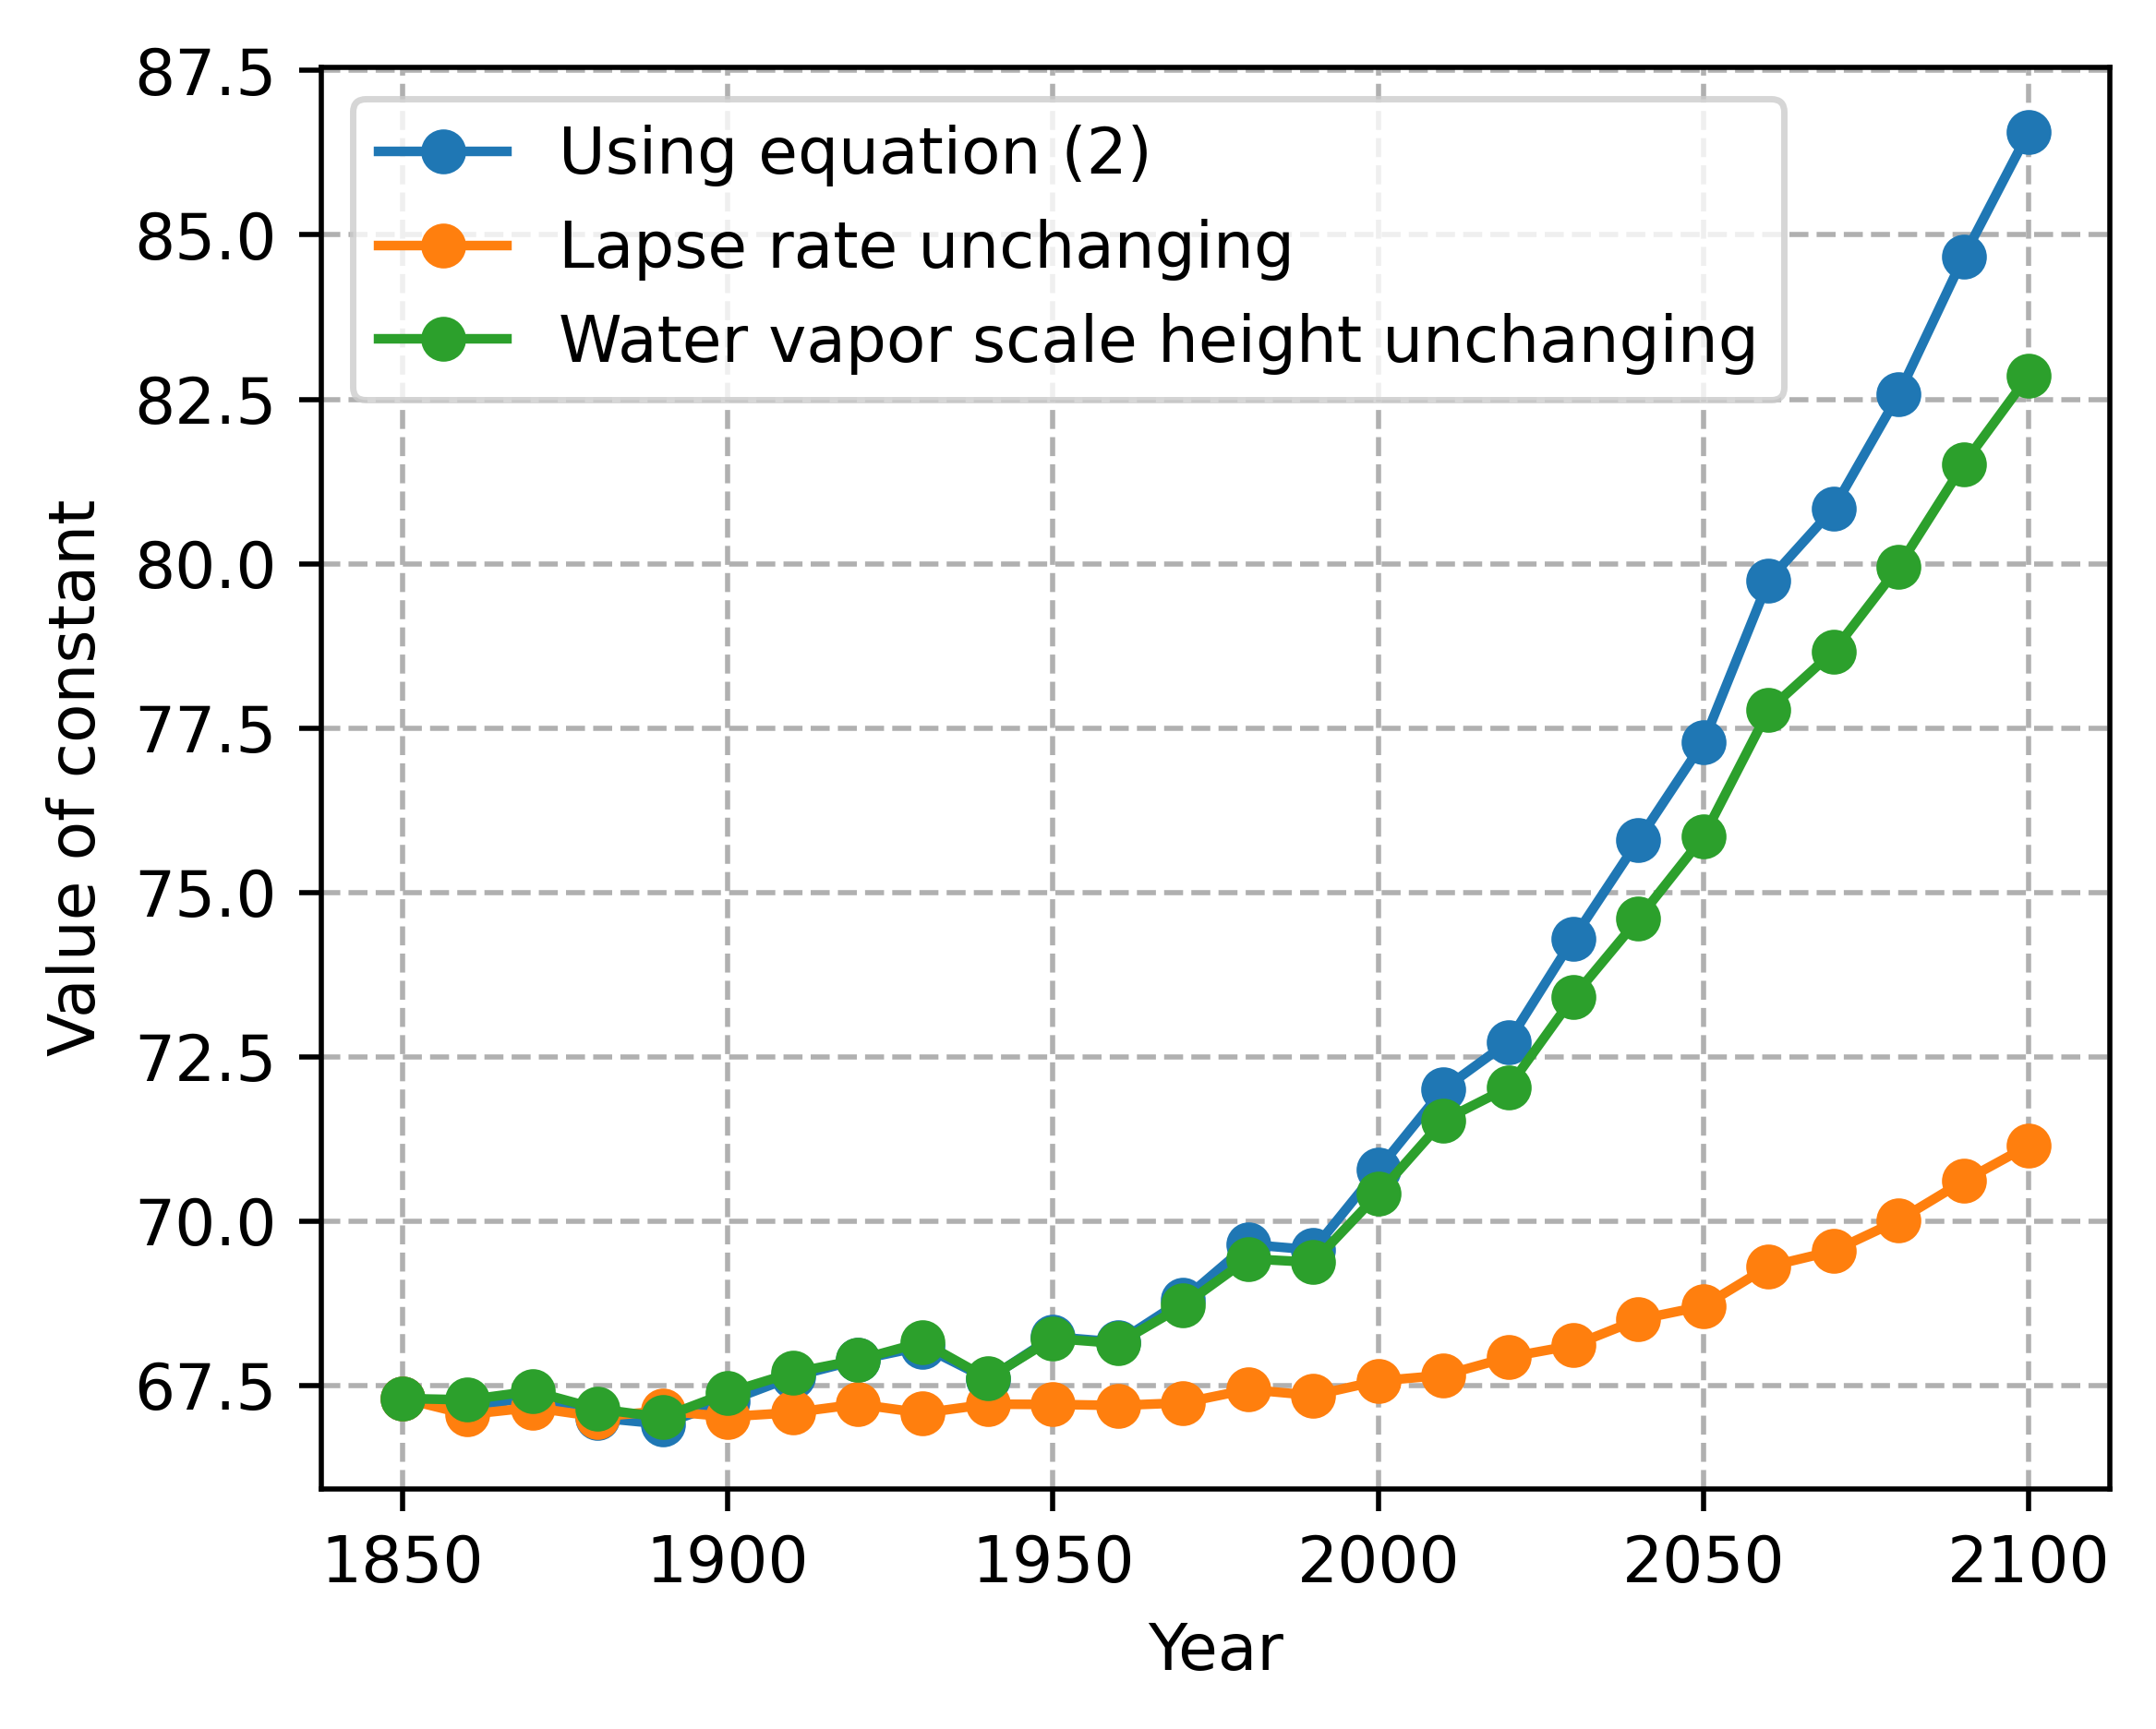

In [4]:
plt.rcParams['figure.figsize'] = [5,4]
X1 = np.arange(1850, 2110, 10)
#plt.plot(X1, predconst[:25], label='Using equation (1)', marker='o')
plt.plot(X1, const, label='Using equation (2)', marker='o')
plt.plot(X1, lambdachangeconst, label='Lapse rate unchanging', marker='o')
plt.plot(X1, gammachangeconst, label='Water vapor scale height unchanging', marker='o')
plt.ylabel('Value of constant')
plt.xlabel('Year')
#plt.title('Decadal JJAS averages, E3SM-1-0')
plt.grid(linestyle='--')
plt.legend()

Text(0.5, 1.0, 'CMIP6 model: CMCC-CM2-SR5')

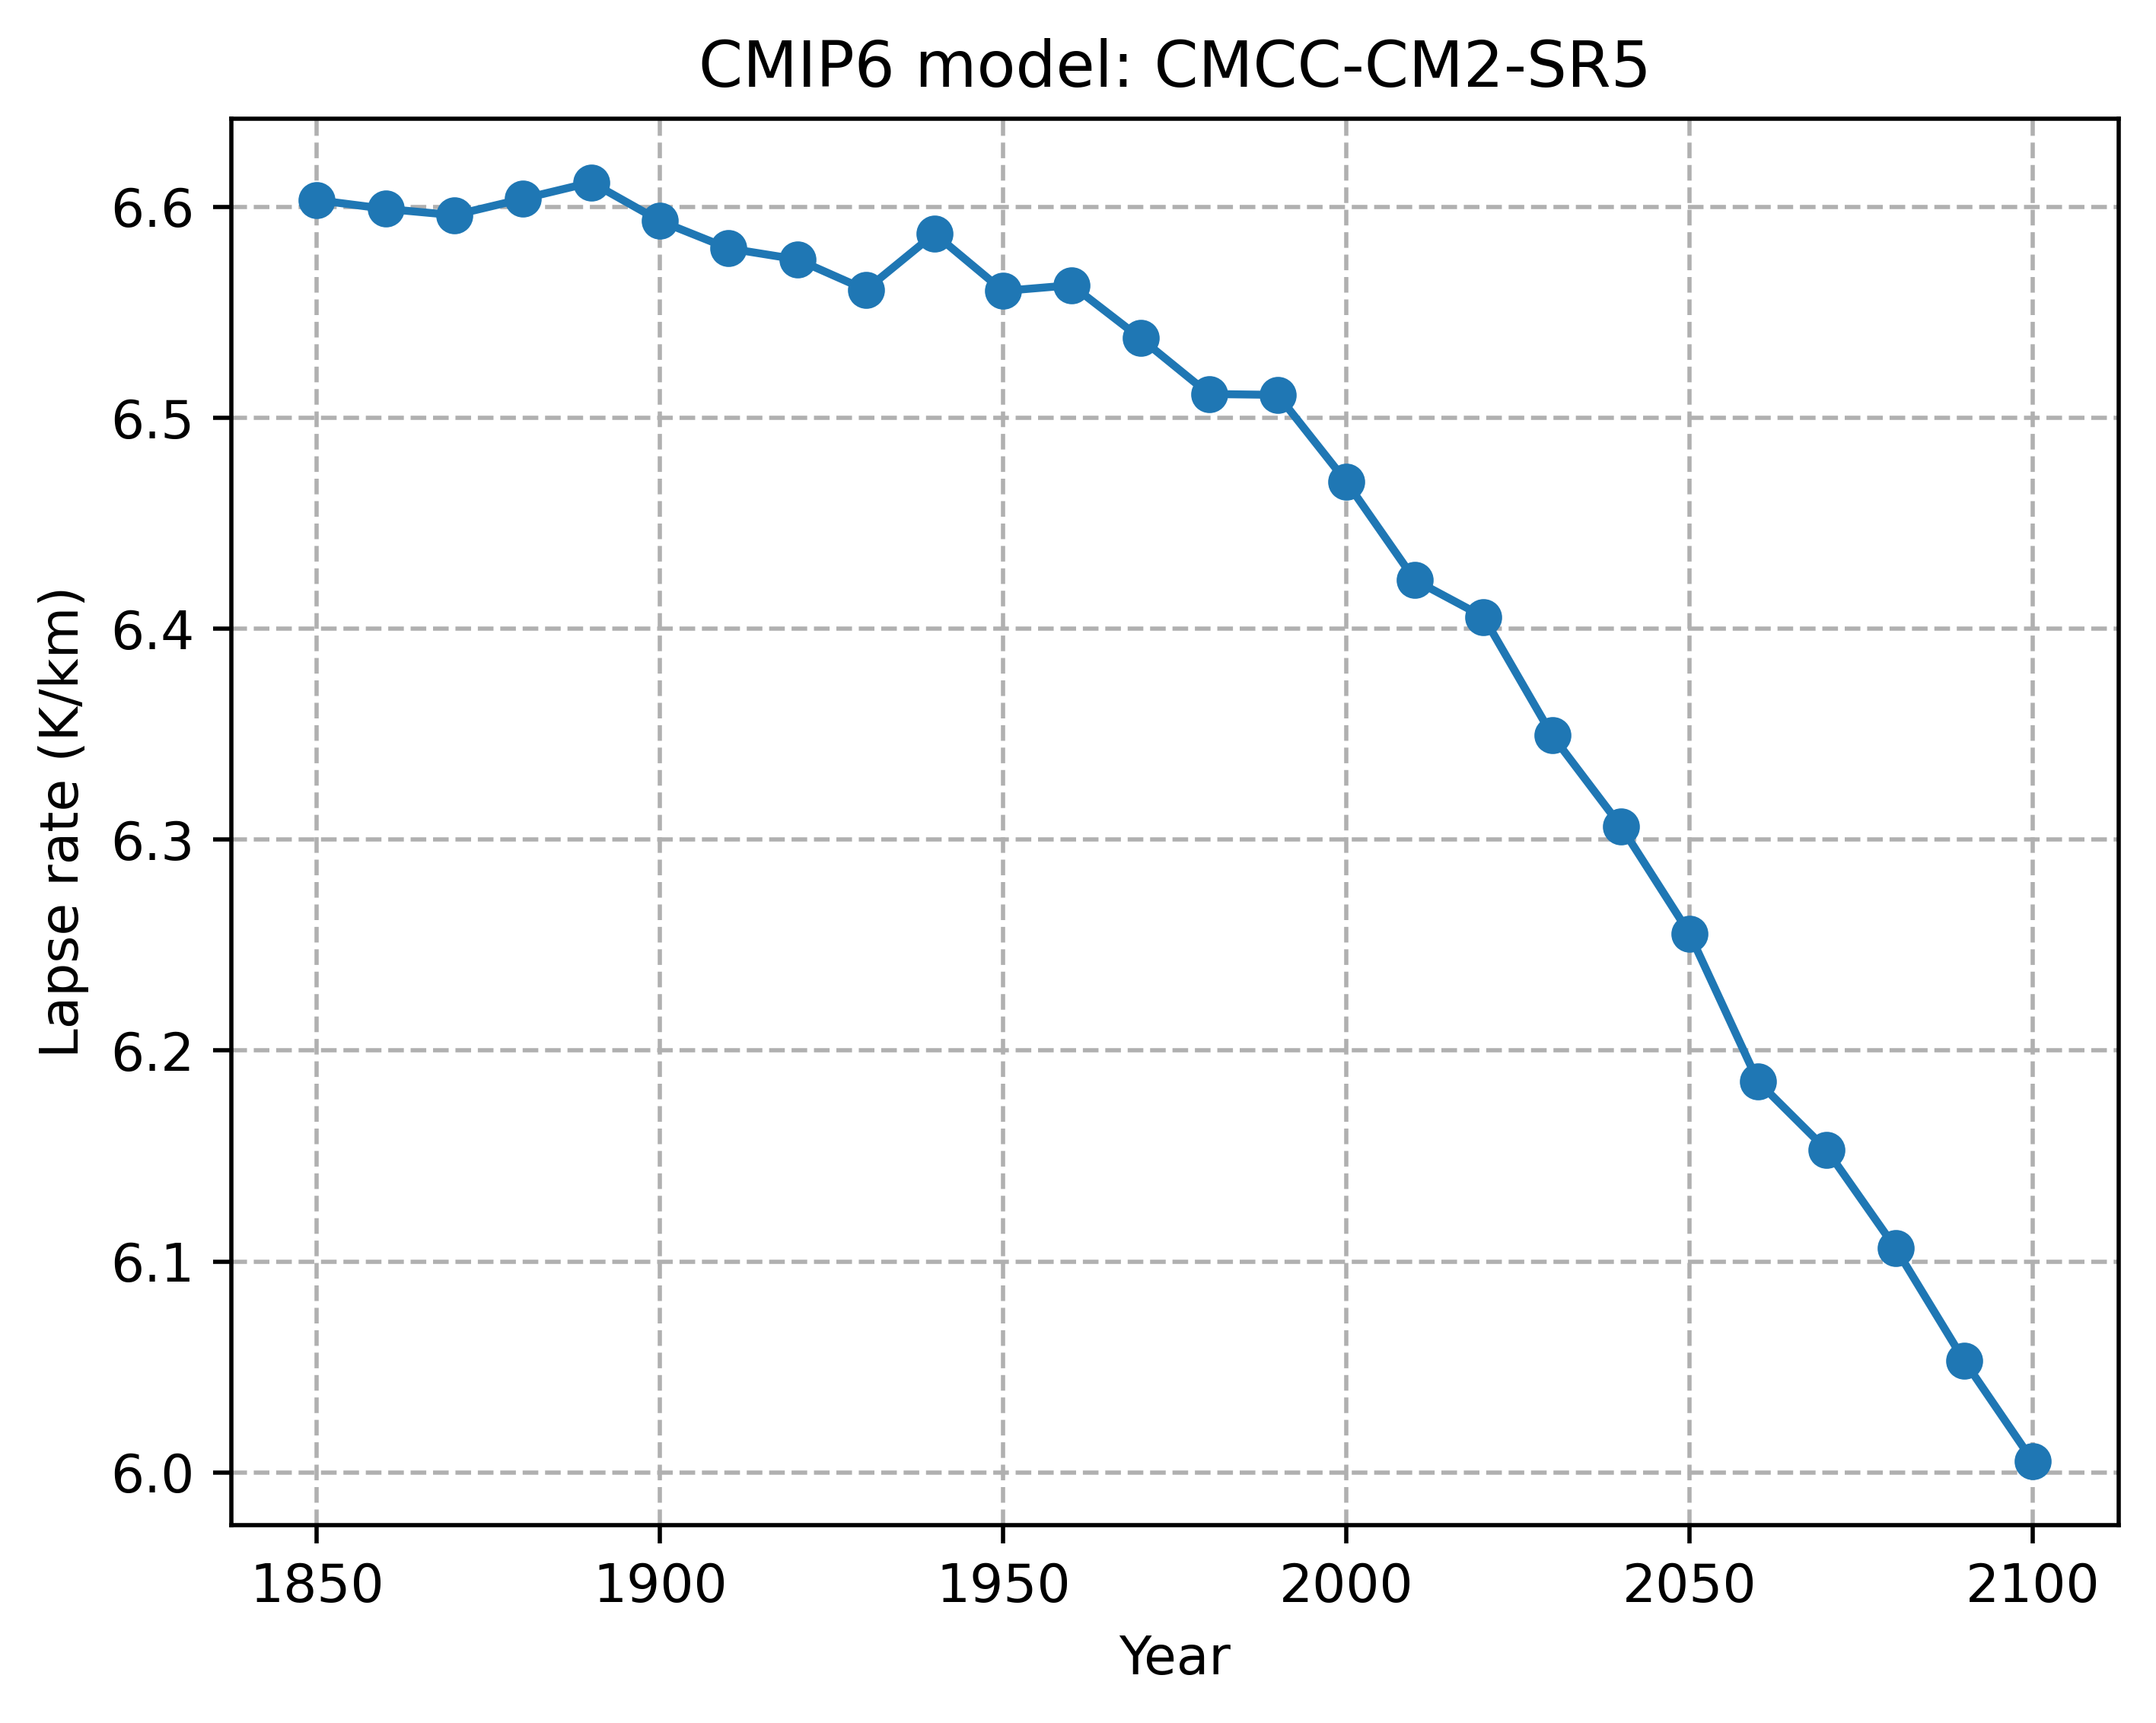

In [8]:
#plt.rcParams['figure.figsize'] = [12,4]
X1 = np.arange(1850, 2110, 10)
plt.plot(X1, 1000*gammalist, marker='o')
plt.ylabel('Lapse rate (K/km)')
plt.xlabel('Year')
plt.grid(linestyle='--')
plt.title('CMIP6 model: CMCC-CM2-SR5')

Text(0.5, 0.98, 'Decadal JJAS averages, CMCC-CM2-SR5')

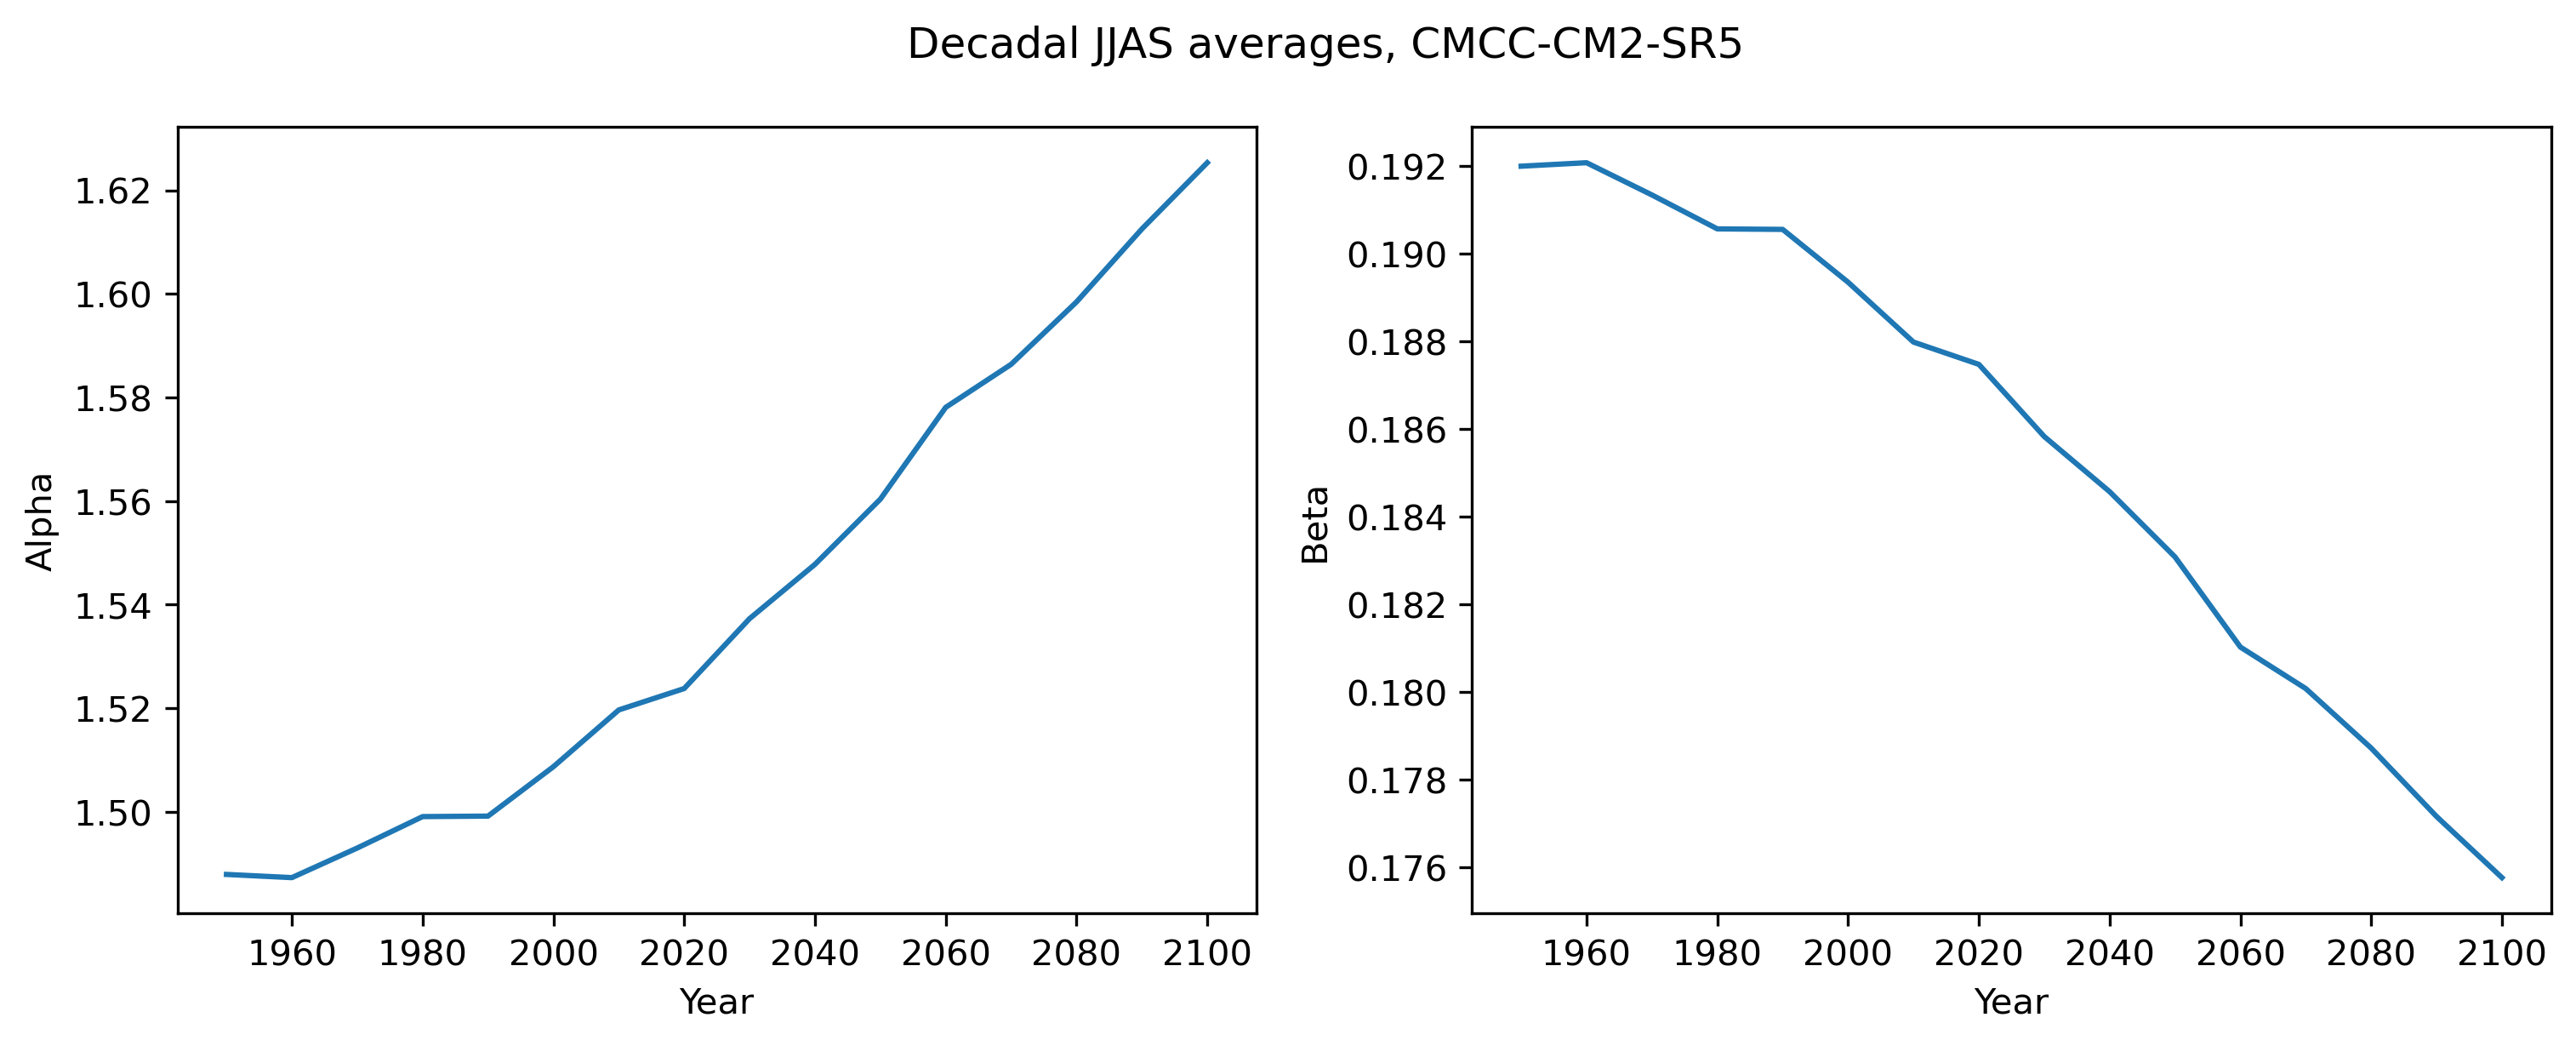

In [64]:
plt.rcParams['figure.figsize'] = [12,4]
plt.subplot(1,2,1)
plt.plot(X, a)
plt.ylabel('Alpha')
plt.xlabel('Year')

plt.subplot(1,2,2)
plt.plot(X, b)
plt.ylabel('Beta')
plt.xlabel('Year')

plt.suptitle('Decadal JJAS averages, CMCC-CM2-SR5')

In [21]:
M1 = Cp*T+Lv*q + z*g

m1 = M1.sel(plev=20000)
m2 = M1.sel(plev=85000)
VMS1=m1-m2

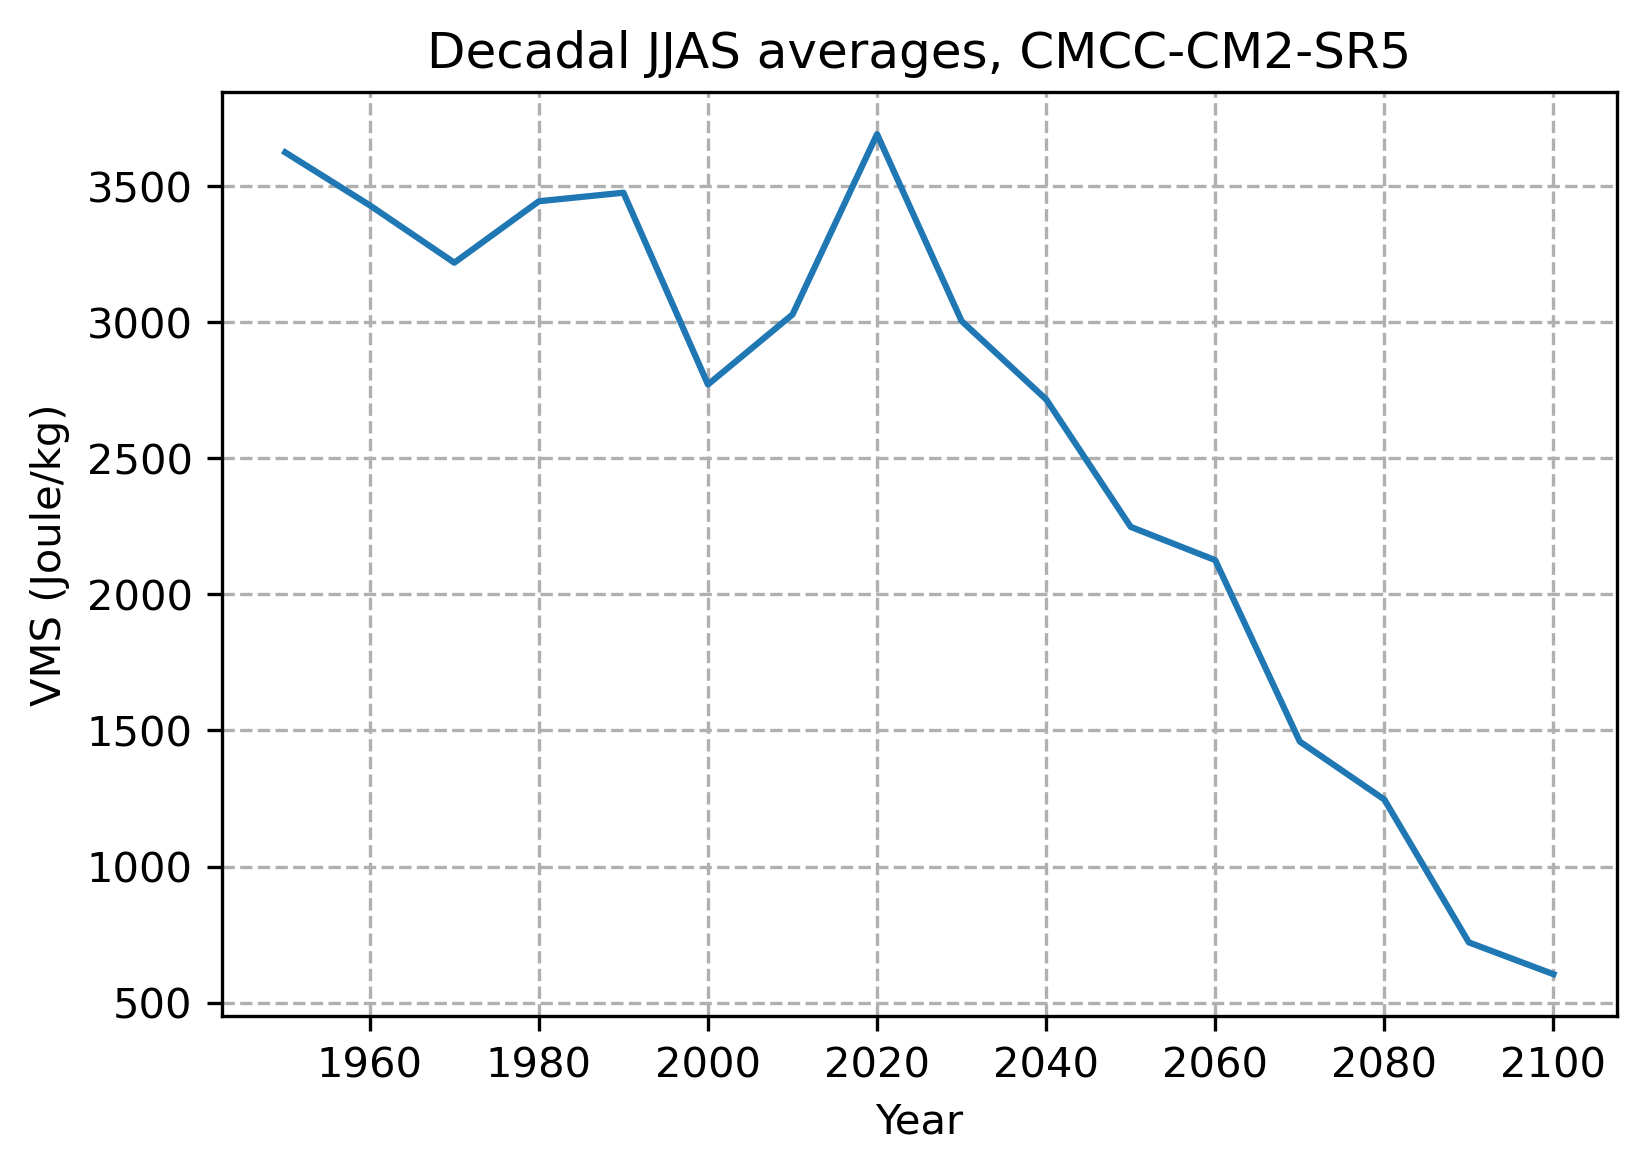

In [25]:
plt.rcParams['figure.figsize'] = [6,4]
plt.plot(X, VMS1)
plt.xlabel('Year')
plt.ylabel('VMS (Joule/kg)')
plt.title('Decadal JJAS averages, CMCC-CM2-SR5')
plt.grid(linestyle='--')

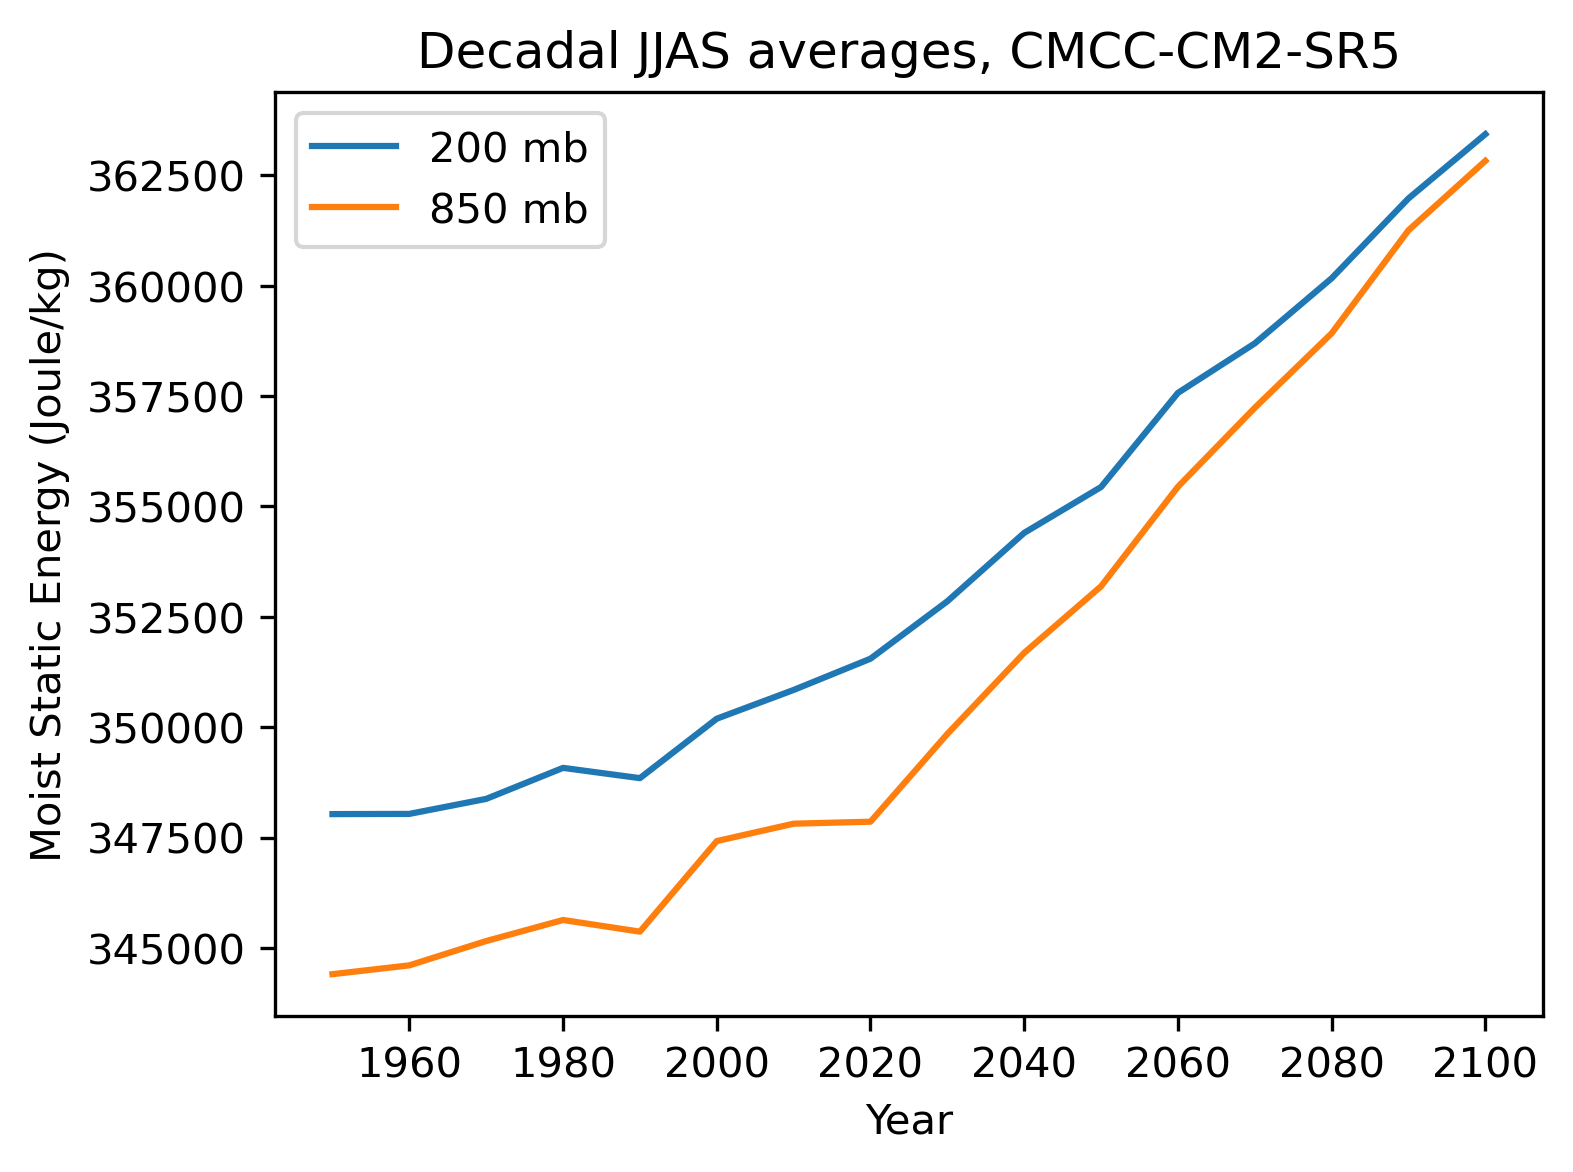

In [10]:
plt.rcParams['figure.figsize'] = [12,4]
plt.subplot(1,2,1)
plt.plot(X, m1, label='200 mb')
plt.xlabel('Year')
plt.ylabel('Moist Static Energy (Joule/kg)')
plt.xlabel('Year')
plt.plot(X, m2, label='850 mb')
plt.xlabel('Year')
plt.title('Decadal JJAS averages, CMCC-CM2-SR5')
plt.legend()

In [12]:
T1 = T.sel(plev=20000)
T2 = T.sel(plev=85000)

(220.0, 300.0)

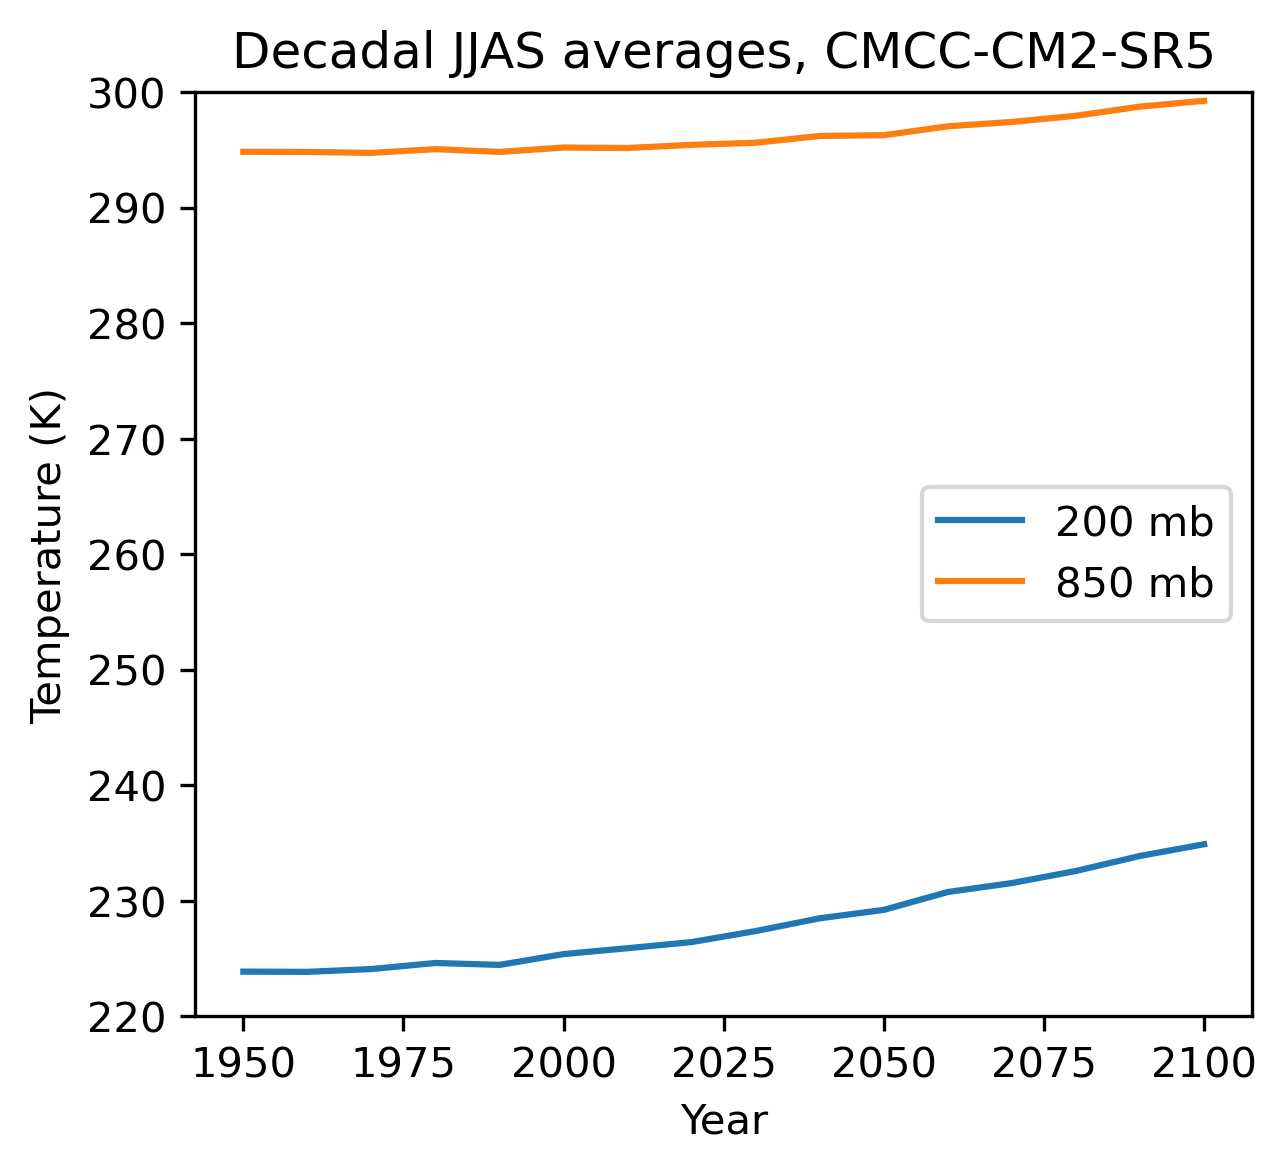

In [33]:
plt.subplot(1,2,1)
plt.plot(X, T1, label='200 mb')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')
plt.xlabel('Year')
plt.plot(X, T2, label='850 mb')
plt.xlabel('Year')
plt.title('Decadal JJAS averages, CMCC-CM2-SR5')
plt.legend()
plt.ylim(220, 300)

In [85]:
exgamma = gammalist[0]
exlambda = lambdalist[0]

In [86]:
exconst = const[0]

In [87]:
list1 = np.linspace(min(lambdalist), max(lambdalist), 50)
dellam=[]
delc1=[]
for  j in list1:
    l=j
    dellam.append(j-exlambda)
    a=g/(Cp*exgamma)
    b=R*exgamma/g
    T0=300
    num = p0*(a-1)*b*(l+2)*Cp*T0
    den = Lv*g*l*(b+1)*(b+2)
    del1 = num/den
    delc1.append(del1-exconst)
    
#variying gamma
#list2 = np.arange(0.1, 0.5, 0.01)
list2 = np.linspace(min(gammalist), max(gammalist), 50)
delgam=[]
delc2=[]
for j in list2:
    l=exlambda
    a=g/(Cp*j)
    b=R*j/g
    delgam.append(j-exgamma)
    T0=300 #remove this later
    num = p0*(a-1)*b*(l+2)*Cp*T0
    den = Lv*g*l*(b+1)*(b+2)
    del1 = num/den
    delc2.append(del1-exconst)

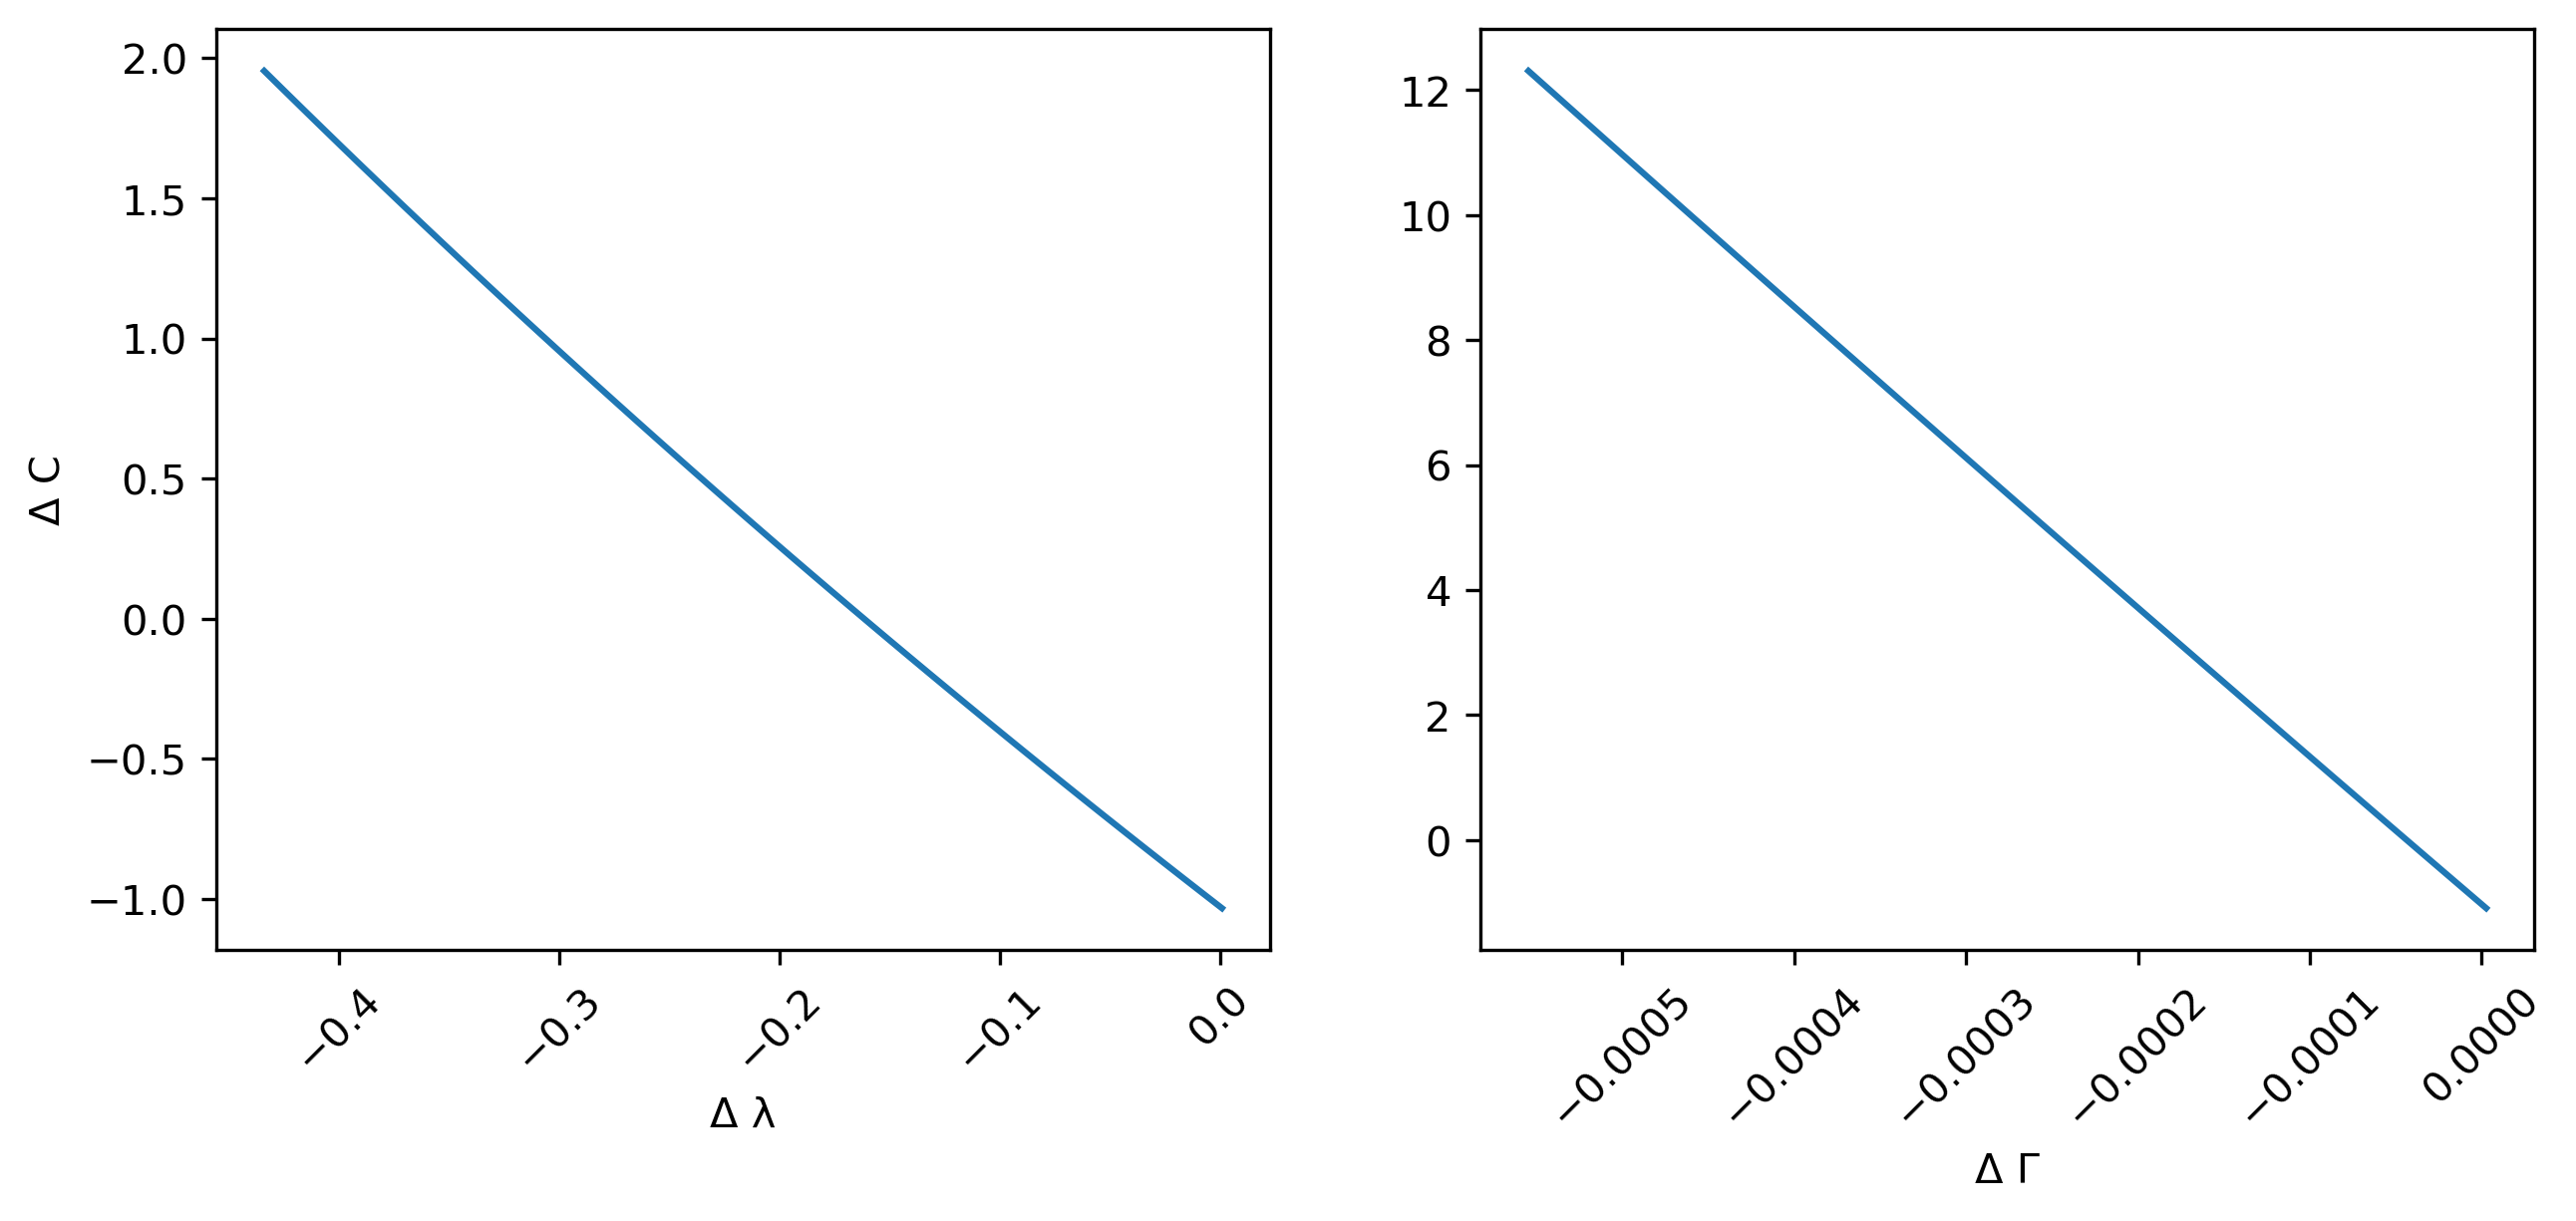

In [88]:
plt.rcParams['figure.figsize'] = [10,4]
plt.subplot(1,2,1)
plt.plot(dellam, delc1)
plt.ylabel(u'\u0394 C')
plt.xlabel(u'\u0394 \u03BB')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.plot(delgam, delc2)
plt.xlabel(u'\u0394 \u0393')
plt.xticks(rotation=45)
plt.show()

plt.suptitle('')